In [ ]:
!pip install ipython-autotime
!unzip DATABASE_EGG.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
Archive:  DATABASE_EGG.zip
   creating: DATABASE_EGG/
   creating: DATABASE_EGG/FLIGHT/
   creating: DATABASE_EGG/FLIGHT/EGG/
   creating: DATABASE_EGG/FLIGHT/EGG/01/
  inflating: DATABASE_EGG/FLIGHT/EGG/01/BASE.txt  
  inflating: DATABASE_EGG/FLIGHT/EGG/01/GAME.txt  
   creating: DATABASE_EGG/FLIGHT/EGG/05/
  inflating: DATABASE_EGG/FLIGHT/EGG/05/BASE.txt  
  inflating: DATABASE_EGG/FLIGHT/EGG/05/GAME.txt  
   creating: DATABASE_EGG/FLIGHT/EGG/09/
  inflating: DATABASE_EGG/FLIGHT/EGG/09/BASE.txt  
  inflating: DATABASE_EGG/FLIGHT/EGG/09/GAME.txt  
   creating: DATABASE_EGG/FLIGHT/EGG/11/
  inflating: DATABASE_EGG/FLIGHT/EGG/11/BASE.txt  
  inflating: DATABASE_EGG/FLIGHT/EGG/11/GAME.txt  
   creating: DATABASE_EGG/FLIGHT/EGG/18/
  inflating: DATABASE_EGG/FLIGHT/EGG/18/BASE.txt  
  inflating: DATABASE_EGG/FLIGHT/EGG/18/GAME.txt  
   creating: DATABASE_EGG/FLIGHT/EGG/20/
  inflating: DATABASE_EGG/FLIGHT/EGG/20/B

# Definicao do Database de cada jogo

In [ ]:
%load_ext autotime

time: 395 µs (started: 2024-11-29 23:25:47 +00:00)


In [ ]:
dbFlightVRSQ = '/content/DATABASE_EGG/FLIGHT/VRSQ/'
dbFlightGAME = '/content/DATABASE_EGG/FLIGHT/GAME/'
dbFlightEGG  = '/content/DATABASE_EGG/FLIGHT/EGG/'
usersFlight  = ['01','05','09','11','18','20','23','26','29','30','32','33','34','35','40','43','47','50']

dbRaceVRSQ = '/content/DATABASE_EGG/RACE/VRSQ/'
dbRaceGAME = '/content/DATABASE_EGG/RACE/GAME/'
dbRaceEGG  = '/content/DATABASE_EGG/RACE/EGG/'
usersRace  = ['03','14','21','22','24','25','31','38','39','44','49']

time: 1.1 ms (started: 2024-11-29 23:25:48 +00:00)


# Funcoes para manipular a base de dados

Dados do xml dos usuarios FILE.xml

In [ ]:
import pandas as pd
import xml.etree.ElementTree as et
import os

def parse_XML(xml_file):

    df_cols = ["UserGenere", "UserAge", "UserExperience", "UserSymptoms", "UserFlicker", "UserGlassesUse", "UserVisionProblems", "UserPosture", "UserEyeDominance", "StaticFrame", "HapticFeedback", "DegreeOfControl", "DofSimulation", "Locomotion", "CameraAutoMovement", "RegionOfInterest", "TimeStamp", "CameraFieldOfView", "PlayerSpeed", "PlayerAcceleration", "CameraRotationX", "CameraRotationY", "CameraRotationZ", "PlayerPositionX", "PlayerPositionY", "PlayerPositionZ", "GameFps", "DiscomfortLevel"]
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    for node in xroot:
        res = []
        for el in df_cols:
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else:
                res.append(None)
        rows.append({df_cols[i]: res[i]
                     for i, _ in enumerate(df_cols)})

    out_df = pd.DataFrame(rows, columns=df_cols)
    return out_df


def parseXmlDirToDataFrame(dir, out = [], debug = False):
    base = dir
    dirs = os.listdir(base)
    dirs.sort()
    data = pd.DataFrame()
    data_out = pd.DataFrame()
    out_training = []
    in_training = []


    #print('parseXmlDirDataFrame -> out', out)
    for label in dirs:
        if label in out :
            #print('label out:',label)
            out_training.append(label)
            for i, fn in enumerate(os.listdir(os.path.join(base, label))):
                if (debug == True):
                    print(os.path.join(base, label, fn))
                df_out = parse_XML(os.path.join(base, label, fn))
                data_out = pd.concat([data_out, df_out])
        else:
            #print('label in:',label)
            in_training.append(label)
            for i, fn in enumerate(os.listdir(os.path.join(base, label))):
                if (debug == True):
                    print(os.path.join(base, label, fn))
                df = parse_XML(os.path.join(base, label, fn))
                data = pd.concat([data, df])

        data = data.drop_duplicates().reset_index(drop=True)
        data_out = data_out.drop_duplicates().reset_index(drop=True)

    #print('df',data)
    #print('df_out',data_out)
    result = [data, in_training, out_training,data_out]
    return result


def getvalueofnode(node):
    """ return node text or None """
    return node.text if node is not None else None

#Essa funcao so serve para eu conferir se os valores de predicao estao parecidos com os valores reais inputados pelos usuarios
def XmlToDataFrameDiscomfort(path):
    # ler e mapeaia a base de dados de xml
    """ main """
    parsed_xml = et.parse(path)
    dfcols = ['DiscomfortLevel']
    df_xml = pd.DataFrame(columns=dfcols)
    for node in parsed_xml.getroot():
        discomfortLevel = node.find('DiscomfortLevel')
        df_xml = df_xml.append(
            pd.Series([str(getvalueofnode(discomfortLevel)).replace(',','.'),
                      ], index=dfcols),
            ignore_index=True)
    base = df_xml
    #Caso o XML possua valores maiores que 1 na coluna discomfortlevel eu converto para 1 (discomfort binario)
    value = base.DiscomfortLevel.astype('int64',copy=False)
    boolean_condition = value > 1
    column_name = "DiscomfortLevel"
    new_value = "1"
    base.loc[boolean_condition, column_name] = new_value
    return base

time: 2.23 s (started: 2024-11-29 23:25:50 +00:00)


dados do VRSQ

In [ ]:
import pandas as pd
import xml.etree.ElementTree as et
import os

#https://dl.uswr.ac.ir/bitstream/Hannan/40901/1/2018%20AppliedErgonomics%20Volume%2069%20May%20%2821%29.pdf
def VRSQScore(df, mode = 'oculumotor'):
    print(df)
    if (mode == 'oculumotor'):
        div = 12
        columns = ["GeneralDiscomfort", "Fatigue", "EyeStraing", "DifficultyFocusing"]
    if (mode == 'disorientation'):
        div = 15
        columns = ["Headache","FulnessOfHead", "BlurredVision", "DizzyEyesClosed", "Vertigo"]

    countBefore = 0
    countAfter = 0

    for c in columns:
        #print(c)
        for index, row in df.iterrows():
            if (index == 0):
                before = int(row[c])
            if (index == 1):
                after = int(row[c])
        countBefore = countBefore + before
        countAfter = countAfter + after

    scoreBefore = ((countBefore/div)*100)
    scoreAfter = ((countAfter/div)*100)
    finalScore = scoreAfter - scoreBefore
    #print(finalScore)
    return finalScore

def GetDFScoresVRSQ(df):
    oculumotor = VRSQScore(df, 'oculumotor')
    disorientation = VRSQScore(df, 'disorientation')
    total = (oculumotor + disorientation)/2
    dataframe = pd.DataFrame({'oculumotor':[oculumotor], 'disorientation':[disorientation], 'total':[total]})
    return dataframe


def parse_XML_VRSQ(xml_file):
    df_cols = ["GeneralDiscomfort", "Fatigue", "EyeStraing", "DifficultyFocusing", "Headache",
               "FulnessOfHead", "BlurredVision", "DizzyEyesClosed", "Vertigo"]

    #print(xml_file)
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    for node in xroot:
        res = []
        for el in df_cols:
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else:
                res.append(None)
        rows.append({df_cols[i]: res[i]
                     for i, _ in enumerate(df_cols)})

    out_df = pd.DataFrame(rows, columns=df_cols)

    result = GetDFScoresVRSQ(out_df)
    return result

def parseXmlVRSQDirToDataFrame(dir, debug = False):
    base = dir
    dirs = os.listdir(base)
    dirs.sort()
    data = pd.DataFrame()
    #print('parseXmlDirDataFrame -> dir', dir)
    for label in dirs:
        for i, fn in enumerate(os.listdir(os.path.join(base, label))):
            if (debug == True):
                print(os.path.join(base, label, fn))
            df = parse_XML_VRSQ(os.path.join(base, label, fn))
            data = pd.concat([data, df], ignore_index=True)
    result = data
    return [result,df]

time: 24.8 ms (started: 2024-11-29 23:25:55 +00:00)


dados do EGG

In [ ]:
import pandas as pd
from pylab import *
from scipy.signal import butter, filtfilt, decimate
from scipy.fft import fft, fftfreq

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def dominant_freq(signal, fs):
    T = 1.0 / fs
    L = signal.size
    fourier = fft(signal)
    freqs = fftfreq(L, T)
    return freqs[argmax(abs(fourier))]

def computeEGG(file):
    fs    = 100.0
    fn    = 4.0

    data = loadtxt(file)
    eggData = data[:,5]
    eggDown = decimate(eggData, int(fs / fn))
    eggF1 = butter_bandpass_filter(eggDown, 0.015, 0.5, fn, order=4)
    eggF2 = butter_lowpass_filter(eggF1, 0.16, fn, order=4)

    domFreq = dominant_freq(eggF2, fn) * 60 # Hz to cpm
    # print(domFreq)
    # plot(eggF2)
    # show()

    return domFreq

def eggToDataFrame(dir):
    base = dir
    dirs = os.listdir(base)
    dirs.sort()
    data = pd.DataFrame()
    for label in dirs:
        eggFreq = []
        eggFiles = os.listdir(os.path.join(base, label))
        eggFiles.sort()
        for i, fn in enumerate(eggFiles):
            if(i == 0):
                eggFreq.append(label)
            eggFreq.append(computeEGG(os.path.join(base, label, fn)))
        df = pd.DataFrame([eggFreq], columns=['ID', 'Base', 'Game'])
        data = pd.concat([data, df], ignore_index=True)
    return data

time: 5.29 ms (started: 2024-11-29 23:26:23 +00:00)


# Funcoes para fazer o PRE PROCESSAMENTO

Pre processamento dos dados do dataframe


In [ ]:
#https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769

def PreProcessDataFrame(df, dropAttributes = [],debug = False):
    #df = oversampling(df)
    #descarto os atributos que nao vao ser utilizados no treinamento

    if 'UserFlicker' in df:
        df = df.drop('UserFlicker', axis=1)
    if 'DegreeOfControl' in df:
        df = df.drop('DegreeOfControl', axis=1)
    if 'UserPosture' in df:
        df = df.drop('UserPosture', axis=1)
    if 'UserSymptoms' in df:
        df = df.drop('UserSymptoms', axis=1)
    if 'UserGlassesUse' in df:
        df = df.drop('UserGlassesUse', axis=1)
    if 'UserVisionProblems' in df:
        df = df.drop('UserVisionProblems', axis=1)
    if 'UserEyeDominance' in df:
        df = df.drop('UserEyeDominance', axis=1)
    if 'StaticFrame' in df:
        df = df.drop('StaticFrame', axis=1)
    if 'RegionOfInterest' in df:
        df = df.drop('RegionOfInterest', axis=1)

    if 'HapticFeedback' in df:
        df = df.drop('HapticFeedback', axis=1)
    if 'DofSimulation' in df:
        df = df.drop('DofSimulation', axis=1)
    if 'Locomotion' in df:
        df = df.drop('Locomotion', axis=1)
    if 'CameraAutoMovement' in df:
        df = df.drop('CameraAutoMovement', axis=1)
    if 'CameraFieldOfView' in df:
        df = df.drop('CameraFieldOfView', axis=1)
    if 'CameraRotationX' in df:
        df = df.drop('CameraRotationX', axis=1)
    if 'CameraRotationY' in df:
        df = df.drop('CameraRotationY', axis=1)
    if 'PlayerPositionX' in df:
        df = df.drop('PlayerPositionX', axis=1)
    if 'PlayerPositionY' in df:
        df = df.drop('PlayerPositionY', axis=1)
    if 'PlayerPositionZ' in df:
        df = df.drop('PlayerPositionZ', axis=1)

    if 'UserGenere' in df:
        #Faco o encoding/ mapping dos valores de atributos categoricos
        df['UserGenere'].unique()
        mapping = {'masculino':1, 'feminino':0}
        df['UserGenere'] = df.apply(lambda row: mapping[row['UserGenere']], axis=1)

    #df['UserGenere'] = df.UserGenere.map({'masculino':1.0, 'feminino':0.0})
    #nominalFeature = pd.get_dummies(df.UserGenere)

    if 'UserAge' in df:
        df['UserAge'].unique()
        mapping = {'18 A 36':0, '37 A 50':1, '+50':1}
        df['UserAge'] = df.apply(lambda row: mapping[row['UserAge']], axis=1)


    if 'UserExperience' in df:
        df['UserExperience'].unique()
        mapping = {'NENHUMA':0, 'ALGUMA':1, 'MUITA':1}
        df['UserExperience'] = df.apply(lambda row: mapping[row['UserExperience']], axis=1)

    if 'DiscomfortLevel' in df:
        df['DiscomfortLevel'].unique()
        mapping = {'0':0, '1':1, '2':1, '3':1}
        df['DiscomfortLevel'] = df.apply(lambda row: mapping[row['DiscomfortLevel']], axis=1)


    #Defino os tipos de cada um dos atributos, categoricos e numericos
    if 'UserGenere' in df:
        df['UserGenere'] = df['UserGenere'].astype('category',copy=True)
    if 'UserAge' in df:
        df['UserAge'] = df['UserAge'].astype('category',copy=False)
    if 'UserExperience' in df:
        df['UserExperience'] = df['UserExperience'].astype('category',copy=False)
    if 'TimeStamp' in df:
        df['TimeStamp'] = df['TimeStamp'].astype('float',copy=False)
    if 'CameraRotationZ' in df:
        df['CameraRotationZ'] = df['CameraRotationZ'].astype('float',copy=False)
    if 'PlayerSpeed' in df:
        df['PlayerSpeed'] = df['PlayerSpeed'].astype('int64',copy=False)
    if 'PlayerAcceleration' in df:
        df['PlayerAcceleration'] = df['PlayerAcceleration'].astype('int',copy=False)
    if 'GameFps' in df:
        df['GameFps'] = df['GameFps'].astype('int64',copy=False)
    if 'DiscomfortLevel' in df:
        df['DiscomfortLevel'] = df['DiscomfortLevel'].astype('int64',copy=False)
    if (debug == True):
        print(df.dtypes)
    if (debug == True):
        print("Droped Attributes ", dropAttributes)
    if (len(dropAttributes) > 0):
        for i in range (len(dropAttributes)):
             if dropAttributes[i] in df:
                 df = df.drop(dropAttributes[i], axis=1)

    return df

def oversampling(df, debug = False):
    # Contagem das classes
    count_class_0, count_class_1 = df["DiscomfortLevel"].value_counts()
    # separacao de classes
    df_class_0 = df[df["DiscomfortLevel"] == 0]
    df_class_1 = df[df["DiscomfortLevel"] == 1]
    if (debug == True):
        print(f"0: {count_class_0}   1: {count_class_1}")
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    df_oversampled = pd.concat([df_class_0, df_class_1_over], axis=0)
    if (debug == True):
        print('Random over-sampling:')
        print(df_oversampled["DiscomfortLevel"].value_counts())
    return df_oversampled

def histBalanc(df):
    plt.hist(df['DiscomfortLevel'])
    plt.tight_layout()
    plt.ylabel('instâncias')
    plt.xlabel('0 - Sem Desconforto | 1 - Com Desconforto')
    plt.title('Balanceamento da classe DiscomfortLevel')

time: 2.91 ms (started: 2024-11-29 23:26:33 +00:00)


# Funcoes de TREINAMENTO

1. Decision Tree

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib
from sklearn.metrics import classification_report
import graphviz
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
#tree = DecisionTreeClassifier()
from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
#one_hot_data = pd.get_dummies(data[['A','B','C']],drop_first=True)
#tree.fit(one_hot_data, data['Class'])

#https://www.dezyre.com/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
#https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
def CSDecisionTreeTraining(df,attributes, depth, _test_size = 0.3, df_out = None, Title2="", CV=False):
    max_depth_value = depth
    attributesNames = attributes
    classNames = ['None', 'Discomfort']
    dt=tree.DecisionTreeClassifier(max_depth=max_depth_value)
    dt.fit(df.iloc[:,:-1].values,df.iloc[:,-1].values)
    fn=attributesNames
    cn=classNames

    userInstances = df.shape[0]
    if type(df_out) is not type(None):
        title = "User Adapt LeaveOneOut - Train:100% A, Test:100% B"

        #data frame de treino
        X_train = df.iloc[:,:-1].values
        y_train = df.iloc[:,-1].values

        #data frame do user que fica de fora do treino
        X_test = df_out.iloc[:,:-1].values
        y_test = df_out.iloc[:,-1].values

        userInstances = df_out.shape[0]

        dt.fit(X_train,y_train)
        y_pred=dt.predict(X_test)
    else:
        title = "Normal Training Varing User - Train:70% A, Test: 30% A"
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=_test_size, shuffle=True)

    if (CV == True):
        # fitting trees of depth 1 to 21
        sm_tree_depths = range(7,22)
        sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

        # plotting accuracy
        plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores,
                               'Accuracy by Decision tree depth on training data - User ID: ', Title2)


        idx_max = sm_cv_scores_mean.argmax()
        sm_best_tree_depth = sm_tree_depths[idx_max]
        sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
        sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
        print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
          sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

        dt=tree.DecisionTreeClassifier(max_depth=sm_best_tree_depth)

    dt.fit(X_train,y_train)
    y_pred=dt.predict(X_test)

    print(title)
    if type(df_out) is not type(None):
        print('number instances (B) = ', userInstances)

    print('X_train = ' + str(len(X_train)) + ' , ' +
          'X_test = ', str(len(X_test)) + ' , ' +
          'y_train = '+ str(len(y_train)) + ' , ' +
          'y_test = '+ str(len(y_test)) + ' , ' +
          'y_pred = ' + str(len(y_pred)) )


    #Get the minimum value of samples in leafs
    from collections import Counter
    #get the leaf for each training sample
    leafes_array = dt.apply(X_train)

    min_value = min(leafes_array)
    print('Depth: ' + str(depth))
    print('Minimum Leaf Sample:' +  str(min(leafes_array)))

    dot_data = tree.export_graphviz(dt, out_file=None,
        feature_names=fn,
        class_names=cn,
        filled=True, rounded=True,
        special_characters=True)


    result = [dt, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,min_value,dot_data]
    return result;


def ShowReports(dtModel,X_train, X_test, y_train, y_test, y_pred, fn, cn, debugDetails = False):
    # Imprimo os reports
    report = classification_report(y_test, y_pred, output_dict=True )
    dot_data = tree.export_graphviz(dtModel, out_file=None,
        feature_names=fn,
        class_names=cn,
        filled=True, rounded=True,
        special_characters=True)
    if (debugDetails == True):
        print(classification_report(y_test, y_pred))
    results = [report, dot_data, metrics.confusion_matrix(y_test,y_pred)]
    return results

time: 1.02 s (started: 2024-11-29 23:26:38 +00:00)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title, title2):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title + title2, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    plt.savefig(os.path.join('CV ' + str(title2)+' .png'),
                dpi=300, format='png', bbox_inches='tight')

time: 2.22 ms (started: 2024-11-29 23:26:43 +00:00)


2. Random Forests

In [ ]:
import platform
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
import time
from scipy.stats import randint as sp_randint
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics._scorer import _SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import joblib
from operator import itemgetter
from tabulate import tabulate

def CSRanfomForestTraining(df, attributes, depth, _test_size=0.3, df_out=None, Title2=""):
    max_depth_value = depth
    attributesNames = attributes
    classNames = ['None', 'Discomfort']
    rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=depth, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=3,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False)
    rf.fit(df.iloc[:,:-1].values,df.iloc[:,-1].values)
    fn=attributesNames
    cn=classNames

    userInstances = df.shape[0]
    if type(df_out) is not type(None):
        title = "User Adapt LeaveOneOut - Train:100% A, Test:100% B"

        #data frame de treino
        X_train = df.iloc[:,:-1].values
        y_train = df.iloc[:,-1].values

        #data frame do user que fica de fora do treino
        X_test = df_out.iloc[:,:-1].values
        y_test = df_out.iloc[:,-1].values

        userInstances = df_out.shape[0]

        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_test)
    else:
        title = "Normal Training - Train:70% A, Test: 30% A"
        X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], test_size=_test_size, shuffle=True)
        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_test)


    print(title)
    if type(df_out) is not type(None):
        print('number instances (B) = ', userInstances)

    print('X_train = ' + str(len(X_train)) + ' , ' +
          'X_test = ', str(len(X_test)) + ' , ' +
          'y_train = '+ str(len(y_train)) + ' , ' +
          'y_test = '+ str(len(y_test)) + ' , ' +
          'y_pred = ' + str(len(y_pred)) )


    param_grid = {
        'n_estimators': [50],
        'max_features': ['sqrt']
    }

    CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
    CV_rfc.fit(X_train, y_train)
    print ('Best Parameters ', CV_rfc.best_params_)


    result = GetCustomAucScoresRF(CV_rfc.best_estimator_,X_train, X_test, y_train, y_test, y_pred)

    aucTrain = result[0]
    aucTest = result[1]

    y_test_score = result[8]
    #print("aucTrain >>>",result[0])
    #print("aucTest >>>",result[1])

    acc = accuracy_score(y_test, CV_rfc.best_estimator_.predict(X_test))

    #Print_Metrics(CV_rfc.best_estimator_,X_train, X_test, y_train, y_test, y_pred,attributesNames,Title2)



    result = [rf, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,
              aucTrain, aucTest, acc, y_test_score]
    return result;

#Not used
def plot_each_decision_tree_from_rf(rf, x_train_values):
    X_train = x_train_values
    sample_id = 0
    for j, tree in enumerate(rf.estimators_):
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold
        print("Decision path for DecisionTree {0}".format(j))
        node_indicator = tree.decision_path(X_train)
        leave_id = tree.apply(X_train)
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]
        print('Rules used to predict sample %s: ' % sample_id)
        for node_id in node_index:
            if leave_id[sample_id] != node_id:
                continue
            if (X_train[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"
            print("decision id node %s : (X_train[%s, %s] (= %s) %s %s)"
                  % (node_id,
                     sample_id,
                     feature[node_id],
                     X_train[sample_id, feature[node_id]],
                     threshold_sign,
                     threshold[node_id]))


def RF_ROC_Curve(rf, auc,X_train,X_test, y_train, y_test, y_test_score, Title2=""):
    one_hot_encoder = OneHotEncoder()
    rf_fit = rf.fit(X_train, y_train)
    fit = one_hot_encoder.fit(rf.apply(X_train))
    #y_predicted = rf.predict_proba(X_test)[:, 1]
    false_positive, true_positive, _ = roc_curve(y_test, y_test_score)

    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(' ROC curve (area = %0.2f)' % auc + ' User ID: ' + str(Title2))
    plt.legend(loc='best')
    plt.savefig(os.path.join('Roc '+str(Title2)+'.png'),
                dpi=300, format='png', bbox_inches='tight')
    plt.show()




def Print_Metrics(best_model, X_train, X_test,y_train, y_test, y_predict_test,feature_columns, Title2 = ""):
    print('\nModel performance on the test data set:')
    print('Train Accuracy.......', accuracy_score(y_train, best_model.predict(X_train)))
    print('Validate Accuracy....', accuracy_score(y_test, best_model.predict(X_test)))

    y_predict_test  = best_model.predict(X_test)
    y_train_score   = best_model.predict_proba(X_train)[:, 1]
    mse             = metrics.mean_squared_error(y_test, y_predict_test)
    #logloss_test    = metrics.log_loss(y_test, y_predict_test)
    accuracy_test   = metrics.accuracy_score(y_test, y_predict_test)
    accuracy_test2  = best_model.score(X_test, y_test)
    F1_test         = metrics.f1_score(y_test, y_predict_test)
    precision_test  = precision_score(y_test, y_predict_test, average='binary')
    precision_test2 = metrics.precision_score(y_test, y_predict_test)
    recall_test     = recall_score(y_test, y_predict_test, average='binary')
    r2_test         = metrics.r2_score(y_test, y_predict_test)

    header = ["Metric", "Test"]
    table  = [
       ["accuracy",  accuracy_test],
       ["precision", precision_test],
       ["F1",        F1_test],
       ["r2",        r2_test],
     ]
    print(feature_columns)
    print(best_model.feature_importances_)
    print(tabulate(table, header, tablefmt="fancy_grid"))
    Plot_predictor_importance(best_model,feature_columns)



def Plot_predictor_importance(best_model, feature_columns):
    feature_importances = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    y_pos  = np.arange(sorted_idx.shape[0]) + .5
    fig, ax = plt.subplots()
    ax.barh(y_pos,
            feature_importances[sorted_idx],
            align='center',
            color='green',
            ecolor='black',
            height=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_columns)
    ax.invert_yaxis()
    ax.set_xlabel('Relative Importance')
    ax.set_title('Predictor Importance')
    plt.show()

time: 846 ms (started: 2024-11-29 23:26:48 +00:00)


In [ ]:
def TrainingProcessWithReport(trainingDatabase,outf = [], outu = [],depth=9, customTest = False, CV = False):
    result = parseXmlDirToDataFrame(trainingDatabase,outu)
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    #print(df_out)
    #df = parseXmlDirToDataFrame('DATABASE_PASSARO/')
    df = PreProcessDataFrame(df,outf)
    df = oversampling(df)
    dt_deep = depth

    if (customTest == True):
        df_out = PreProcessDataFrame(df_out,outf)

    #Training
    attributes = df.columns[:-1]


    if len(outu) == 0:
        title = ""
    else:
        title = outu[0]

    if (customTest == True):
        #print('Traning Process -> Custom Test True')
        DecisionTreeResults = CSDecisionTreeTraining(df,attributes,dt_deep,0.3,df_out,title,CV)
    else:
        DecisionTreeResults = CSDecisionTreeTraining(df,attributes,dt_deep,0.3,None,title,CV)

    # result = [dt, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value]
    dtModel = DecisionTreeResults[0]
    X_train= DecisionTreeResults[1]
    X_test= DecisionTreeResults[2]
    y_train= DecisionTreeResults[3]
    y_test= DecisionTreeResults[4]
    y_pred = DecisionTreeResults[5]
    fn = DecisionTreeResults[6]
    cn = DecisionTreeResults[7]
    attributesNames = DecisionTreeResults[8]
    max_depth_value = DecisionTreeResults[9]
    min_leaf_value = DecisionTreeResults[10]

    print('in training(fn): ' , attributes.tolist())
    print('in training(users): ' , in_training)

    reportResults = ShowReports(dtModel,X_train, X_test, y_train, y_test, y_pred,fn,cn, True)
    classificationReport = reportResults[0]
    dotData = reportResults[1]

    #print('Out of Training :', out_training)
    results = [dtModel, attributes.tolist(), in_training,
               classificationReport, fn, dotData, X_train, X_test, y_train, y_test, y_pred, min_leaf_value]
    return results

def RFTrainingProcessWithReport(trainingDatabase,outf = [], outu = [],depth=9, customTest = False):
    result = parseXmlDirToDataFrame(trainingDatabase,outu)
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    #print(df_out)
    #df = parseXmlDirToDataFrame('DATABASE_PASSARO/')
    df = PreProcessDataFrame(df,outf)
    df = oversampling(df)
    dt_deep = depth

    if (customTest == True):
        df_out = PreProcessDataFrame(df_out,outf)

    #Training
    attributes = df.columns[:-1]

    if (customTest == True):
        #print('Traning Process -> Custom Test True')
        RFResults = CSRanfomForestTraining(df,attributes.values,dt_deep,0.3,df_out,outu[0])
    else:
        RFResults = CSRanfomForestTraining(df,attributes.values,dt_deep,0.3,None,outu[0])

    model  = RFResults[0]
    X_train= RFResults[1]
    X_test= RFResults[2]
    y_train= RFResults[3]
    y_test= RFResults[4]
    y_pred = RFResults[5]
    fn = RFResults[6]
    cn = RFResults[7]
    attributesNames = RFResults[8]
    max_depth_value = RFResults[9]
    aucTrain = RFResults[10]
    aucTest = RFResults[11]
    acc = RFResults[12]
    y_test_score = RFResults[13]

    #reportResults = ShowReports(model,X_train, X_test, y_train, y_test, y_pred,fn,cn, True)
    #classificationReport = reportResults[0]
    #print ("AUC Train: ",aucTrain)
    #print ("AUC Test: ",aucTest)

    #RF
    result = [model, X_train, X_test, y_train, y_test, y_pred,fn,cn,attributesNames,max_depth_value,aucTrain,aucTest,acc,y_test_score]

    print('training(fn): ' , attributes.tolist())
    print('training(users): ' , in_training)
    print('accuracy: ', acc)
    return result

def GetCustomReportAccF1Auc(results):
    dtModel =  results[0]
    classificationReports = results[3]
    X_train = results[6]
    X_test = results[7]
    y_train = results[8]
    y_test = results[9]
    y_pred = results[10]

    auc_results = get_auc_scores(dtModel, X_train, X_test, y_train, y_test)
    y_test_score_auc = auc_results[1]

    try:
        f1_0 = classificationReports['0']['f1-score']
        f1_1 = classificationReports['1']['f1-score']
    except:
        f1_0 = -1
        f1_1 = -1

    macroF1 = classificationReports['macro avg']['f1-score']
    accuracy = classificationReports['accuracy']
    auc_train_score = auc_results[2]
    auc_test_score = auc_results[3]

    n_results = [accuracy, f1_0, f1_1, macroF1, auc_train_score, auc_test_score,
                dtModel, classificationReports, X_train, X_test,
                y_train, y_test, y_pred, y_test_score_auc]
    return n_results


def GetCustomAucScoresRF(Model,X_train, X_test, y_train, y_test, y_pred):
    auc_results = get_auc_scores(Model, X_train, X_test, y_train, y_test)
    y_test_score_auc = auc_results[1]

    auc_train_score = auc_results[2]
    auc_test_score = auc_results[3]

    print("Training AUC: " + str(auc_train_score))
    print("Testing AUC: " + str(auc_test_score))
    n_results = [auc_train_score, auc_test_score,
                Model, X_train, X_test,
                y_train, y_test, y_pred, y_test_score_auc]

    return n_results


#LeaveOneOut adaptado por usuario
# O leave one out original eh por instancia, neste caso , essa eh uma variacao
# que considera um usuario com n instancias por vez
def LeaveOneOutUser(trainingDatabase,usersIds=[],features=[],depth=9, plotRoc = False,
                    customTest = False, cv = False, debug = False):
    models = []
    min_leaf_values = []
    auc_scores = []
    if (customTest == False):
        print ('All Users')
        results = TrainingProcessWithReport(trainingDatabase,features,[],depth,False,cv)
        c_report = GetCustomReportAccF1Auc(results)

        if (plotRoc == True):
            plot_roc_curve(c_report[11], c_report[13], '[None]')
    #print('\n')
    for i in range(0,len(usersIds)):
            out = [usersIds[i]]
            print('\n')
            print(i, '- Without ' +  str(out))
            results = TrainingProcessWithReport(trainingDatabase,features,out,depth,customTest,cv)
            models.append(results[0])
            min_leaf_values.append(results[11])
            c_report = GetCustomReportAccF1Auc(results)
            auc_scores.append([c_report[4], c_report[5]])
            if (plotRoc == True):
                plot_roc_curve(c_report[11], c_report[13], str(out[0]))
    if debug == True:
        #minimum leaf samples value, auc scores
        return [models,min_leaf_values,auc_scores]
    else:
        return models


#http://blog.cypresspoint.com/2017/10/11/sklearn-random-forest-classification.html

#LeaveOneOut adaptado por usuario
# O leave one out original eh por instancia, neste caso , essa eh uma variacao
# que considera um usuario com n instancias por vez
def RFLeaveOneOutUser(trainingDatabase,depth,usersIds=[],features=[], plotRoc = False, customTest = False, debug = False):
    models = []
    aucScores = []
    if (customTest == False):
        print ('All Users')
        results = RFTrainingProcessWithReport(trainingDatabase,features,[],depth,False)
        Model = results[0]
        X_train = results[1]
        X_test = results[2]
        y_train = results[3]
        y_test = results[4]
        y_pred = results[5]
        aucTrain = results[10]
        aucTest = results[11]
        acc = results[12]
        y_test_score = results[13]
        #c_report = GetCustomAucScoresRF(Model, X_train, X_test, y_train, y_test, y_pred)

        #y_test_score = c_report[8]

        if (plotRoc == True):
            #RF_ROC_Curve(Model, aucTest,X_train,X_test, y_train, y_test,y_test_score, Title2="")
            plot_roc_curve(y_test, y_test_score, ' user out [None]','Random Forest')
    #print('\n')
    for i in range(0,len(usersIds)):
            out = [usersIds[i]]
            print('\n')
            print(i, '- Without ' +  str(out))
            results = RFTrainingProcessWithReport(trainingDatabase,features,out,depth,customTest)

            Model = results[0]
            X_train = results[1]
            X_test = results[2]
            y_train = results[3]
            y_test = results[4]

            y_pred = results[5]
            aucTrain = results[10]
            aucTest = results[11]

            models.append(results[0])
            aucScores.append([aucTrain,aucTest])
            #c_report = GetCustomAucScoresRF(Model, X_train, X_test, y_train, y_test, y_pred)

            acc = results[12]
            y_test_score = results[13]

            #aucScores.append([c_report[4], c_report[5]])
            if (plotRoc == True):
                #RF_ROC_Curve(Model, aucTest,X_train,X_test, y_train, y_test, y_test_score , Title2="")
                plot_roc_curve(y_test, y_test_score, ' user out ' + str(out), 'Random Forest')
    if debug == True:
        return [models,aucScores]
    else:
        return models

time: 43.6 ms (started: 2024-11-29 23:26:54 +00:00)


# Funcoes de Analise dos dados de treino

In [ ]:
import graphviz
from graphviz import Source
from sklearn import tree
from sklearn.tree import _tree
from sklearn.metrics import (roc_curve, auc, roc_auc_score,confusion_matrix)
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_text


def plotDecisionTreeGraph(dot_data):
    #Visualizacao da Arvore gerada no treinamento
    graph = graphviz.Source(dot_data)
    return graph

def plotDecisionTreetext(dtModel, X_train):
    tree_text = export_text(dtModel, feature_names=list(X_train))
    return tree_text

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i]
                    if i != _tree.TREE_UNDEFINED else "undefined!"
                    for i in tree_.feature]
    print("def tree({}):".format(", ".join(feature_names)))
    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))
    recurse(0, 1)


from sklearn.metrics import roc_auc_score, accuracy_score
def roc_auc_score_FIXED(y_true, y_pred):
    if len(np.unique(y_true)) == 1: # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred)

def get_auc_scores(clf, X_train, X_test, y_train, y_test):
    y_train_score = clf.predict_proba(X_train)[:, 1]
    y_test_score = clf.predict_proba(X_test)[:, 1]

    try:
        auc_train = roc_auc_score_FIXED(y_train, y_train_score)
        auc_test = roc_auc_score_FIXED(y_test, y_test_score)
        results = [y_test, y_test_score,auc_train, auc_test]
    except ValueError:
        results = [y_test,y_test_score,auc_train,0]
        pass

    return results


def plot_roc_curve(y_test, y_test_score, Title2 = "", lab='Decision Tree'):
    import os
    import numpy as np
    import matplotlib.pyplot as plt


    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()

    if (lab == 'Decision Tree'):
        c = 'slateblue'
    else:
        c= 'darkorange'
    plt.plot(fpr, tpr, color=c, label=lab)
    plt.plot([0, 1], [0, 1], "k")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(' ROC curve (area = %0.2f)' % roc_auc + ' User ID: ' + str(Title2) )
    plt.legend(loc="best")
    plt.savefig(os.path.join('Roc - User Id['+str(Title2)+'].png'),
                dpi=300, format='png', bbox_inches='tight')
    # use format='svg' or 'pdf' for vectorial pictures
    plt.show()
    #plt.close()

def plot_cm(classifier, X_test, y_test):
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay(classifier, X_test, y_test,
                                     display_labels=["none","discomfort"],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize,values_format = '.2f')
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)
    plt.show()

time: 5.44 ms (started: 2024-11-29 23:27:01 +00:00)


# Funcoes de Predição


In [ ]:
def predict_discomfort_rf(df, rfModel, fn, debug=False):
    discomfort0 = 0
    discomfort1 = 0

    XX_test = df

    if (XX_test[XX_test.columns[-1]].name == 'DiscomfortLevel'):
        values = df.iloc[:,:-1].values
    else:
        values = df.iloc[:,:].values


    totalCauses = []
    totalCausesDepth = []
    totalRawpred = []
    totalRawcauses = []
    samplesCount = 1
    for value in values:
        discomfortPred = rfModel.predict(value.reshape(1, -1))
        index = 1

        print('Sample: '+ str(samplesCount) + ' of ' + str(len(values) ) )
        print('Sample: ', str(value))
        if (discomfortPred == 1):
            print('  Discomfort Predicted by RF')
            for dt in rfModel.estimators_:
                print('    Estimator ' + str(index)+ ' of ' + str(len(rfModel.estimators_)) )
                results = predict_discomfort(df,dt,fn,debug=False)
                causes = results[0]
                rules =  results[1]
                d0 = results[2]
                d1 = results[3]
                raw_pred = results[4]
                raw_causes = results[5]
                causes_node_depth = results[6]

                for item in raw_pred:
                    totalRawpred.append(item)

                for item in raw_causes:
                    totalRawcauses.append(item)

                for item in causes:
                    totalCauses.append(item)

                for item in causes_node_depth:
                    totalCausesDepth.append(item)

                index = index + 1
        else:
            print('None Discomfort Predicted by RF')

        if (discomfortPred == 1): # sum the discomfort 0 and 1
            discomfort1 = discomfort1 + 1
        else:
            discomfort0 = discomfort0 + 1
        samplesCount = samplesCount + 1
    return [totalCauses, totalCausesDepth,totalRawpred,totalRawcauses]
    #feature_columns = values
    #rfModel.feature_importances_

# Example : https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def predict_discomfort(dfWindow,dtModel,fn, debug=False): #0 causes , 1 rules, 2 discomfort0, 3 discomfor1
    causes = []
    rules = []
    discomfort0 = 0
    discomfort1 = 0
    raw_causes = []
    raw_pred = []
    raw_nodes_depth = []
    causes_node_depth = []


    if (dfWindow[dfWindow.columns[-1]].name == 'DiscomfortLevel'):
        values = dfWindow.iloc[:,:-1].values
    else:
        values = dfWindow.iloc[:,:].values

    index = 0
    for value in values: # Percorro todoas as intancias da janela
        dictionary = dict(zip(fn, value))
        #Prever o desconforto usando o modelo de arvore de decisao
        # e a instancia separada para teste
        discomfortPred = dtModel.predict(value.reshape(1, -1))

        dtDepth = dtModel.get_depth()
        #armazeno todos os resultados de predicao binaria do desconforto
        raw_pred.append(discomfortPred[0])

        # Contabilizo os resultados da predicao binaria
        if (discomfortPred == 1): # sum the discomfort 0 and 1
            discomfort1 = discomfort1 + 1
        else:
            discomfort0 = discomfort0 + 1

        # Se o desconforto for igual a 1 , entao realizo a analise dos caminhos da arvore
        if (discomfortPred == 1): #causes and rules
            if (debug == True):
                print ("> Instance: ", dictionary)
            decision = "None"

            if (discomfortPred == 1):
                decision = "Discomfort"

            if (debug == True):
                print("> Discomfort Prediction : ", decision)

            #---- Atributos da Preditor ---------------------------------------------------------------
            # numero de nodes da arvore predita
            n_nodes = dtModel.tree_.node_count
            # filhos da esquerda
            children_left = dtModel.tree_.children_left
            # filhos da direita
            children_right = dtModel.tree_.children_right
            #Capturo as informacoes do caminho percorrido na arvore de decisao para prever o desconforto
            node_indicator = dtModel.decision_path(value.reshape(1, -1))#X_test.iloc[0:1]
            #capturo tods os indices de nos do caminho do desconforto ate a folha
            node_indices = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
            # capturo todos os threashold
            threshold = dtModel.tree_.threshold
            #capturo todos os nomes de features de acordo com o path em ordem
            features = dtModel.tree_.feature
            # ------------------------------------------------------------------------------------------
            #feat_importance = dtModel.tree_.compute_feature_importances(normalize=True)
            #print (feat_importance)


            # --- Computar o peso de cada node usando a altura ------------------------------------------
            #The tree structure can be traversed to compute various properties such
            # as the depth of each node and whether or not it is a leaf.
            node_depth = np.zeros(shape=n_nodes, dtype=np.float32)
            is_leaves = np.zeros(shape=n_nodes, dtype=bool)
            stack = [(0, -1)]  # seed is the root node id and its parent depth
            while len(stack) > 0:
                node_id, parent_depth = stack.pop()

                score =  round ( ((dtDepth - (parent_depth + 1) ) ),2 )

                node_depth[node_id] = score

                # If we have a test node
                if (children_left[node_id] != children_right[node_id]):
                    stack.append((children_left[node_id], parent_depth + 1))
                    stack.append((children_right[node_id], parent_depth + 1))
                else:
                    is_leaves[node_id] = True

            # -----------------------------------------------------------------------------------------

            rule_c = []
            inst_causes_tmp = []
            inst_nodes_depth = []


            # Contabilizacao de causas e pesos relativos a altura --------------------------------------
            #Printo os resultados dos atributos mais relevantes para a predicao do desconforto
            #tambem printo o a ramificacao (decisao)
            if (debug == True):
                print("> Node Discomfort Importance")

            # varro todos o array de indices de nodes associados ao desconforto 1  de 1 instancia
            for ni in node_indices:
                threshold_sign=">" if dfWindow.iloc[index, features[ni]] > threshold[ni] else "<="
                if (debug == True):
                    print(f'Node {ni}, {dfWindow.columns[features[ni]]}, {dfWindow.iloc[index,features[ni]]} {threshold_sign} {threshold[ni]}')

                # Adiciono em uma lista de features (causas)
                causes.append(dfWindow.columns[features[ni]])

                #Adiciono uma lista de duplas features (causa) , peso relativo (node_depth) ja calculado
                featurepair = [dfWindow.columns[features[ni]],node_depth[ni]]
                causes_node_depth.append(featurepair)

                inst_causes_tmp.append(dfWindow.columns[features[ni]])
                rule_c.append(str(dfWindow.columns[features[ni]]) + str(threshold_sign) +  str(threshold[ni]))

            rules.append(rule_c)
            raw_causes.append(inst_causes_tmp)
            #raw_nodes_depth.append(inst_nodes_depth)
            # ------------------------------------------------------------------------------------------
        else:
            raw_causes.append("None")
        index = index + 1

        if (debug == True):
            print("\n")

    pResults = [causes, rules, discomfort0, discomfort1,raw_pred, raw_causes,causes_node_depth]
    return pResults

time: 2.96 ms (started: 2024-11-29 23:27:06 +00:00)


# Funcoes de Exibicao de Resultados

In [ ]:
def calculate_causes_feqweighted(causes, weights):
    (unique, counts) = np.unique(causes, return_counts=True)

    f_causes = []
    v_causes = []
    v_causes_n = []
    for c in unique:
        f_causes.append(c)
        value = 0
        for i in range (0,len(causes)):
            if causes[i] == c:
                #print("weight:", weights[i])
                value = value + weights[i]
        v_causes.append(value)
    total = 0

    for i in v_causes:
        total = total + i


    for value in v_causes:
        v_causes_n.append(round( (100 * value / total),2) )


    v1 = []
    v2 = []
    for i in range(0,len(v_causes_n)):
        v1.append(f_causes[i])
        v2.append(v_causes_n[i])

    dic = dict(zip(v1, v2))
    sorted_d = sorted(dic.items(), key=lambda x: x[1], reverse=True)

    print (f_causes)
    #print(v_causes)
    print(v_causes_n)

    return sorted_d

# funcao que calcula e exibe a frequencia das causas (atributos)
# em todas as situacoes que houve desconforto igual a 1 (positivo)
def show_causes(causes):
    # Imprimo os atributos de maiores ocorrencias da interacao
    (unique, counts) = np.unique(causes, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    l = frequencies
    v1 = []
    v2 = []
    for i in range(0,len(l)):
        v1.append(l[i][0])
        v2.append(l[i][1])
    dic = dict(zip(v1, v2))
    sorted_d = sorted(dic.items(), key=lambda x: x[1], reverse=True)
    return sorted_d

def show_causes_normalized(causes, percent = False):
    dic = show_causes(causes)
    total= 0
    v1 = []
    v2 = []
    # somo todos os valores do dicionario
    for i in range (0, len(dic)):
        total = dic[i][1].astype(float) + total

    for i in range (0, len(dic)):
        value = dic[i][1].astype(float)
        if percent == True:
            normalized = (100 *  value / total)
        else:
            normalized = value
        v1.append(dic[i][0])
        v2.append(normalized.astype(float))
        dic2 = dict(zip(v1, v2))
    sorted_d = sorted(dic2.items(), key=lambda x: x[1], reverse=True)
    return sorted_d

# Discomfort Percent function
def show_discomfortPercent(d0, d1):
    totalDiscomfort = d0 + d1
    NoneDiscomfortNormalized = (100 * d0 / totalDiscomfort)
    DiscomfortNormalized = (100 * d1 / totalDiscomfort)
    print ("None Discomfort: ", round(NoneDiscomfortNormalized, 2), '%')
    print ("Discomfort: ", round(DiscomfortNormalized,2), '%')


def plot_causes_graph(array_causes,userId, normalized = False):
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    #https://htmlcolorcodes.com
    colors = dict(zip(
    ["UserGenere",
     "UserAge",
     "UserExperience",
     "CameraFieldOfView",
     "PlayerSpeed",
     "PlayerAcceleration",
     "CameraRotationZ",
     "GameFps",
     "TimeStamp"],
    ['#D7DBDD',
     '#99A3A4',
     '#616A6B',
     '#5DADE2',
     '#48C9B0',
     '#F4D03F',
     '#D35400',
     '#34495E',
     '#0E6251']
    ))


    top=array_causes
    labels, values = zip(*top)
    x = labels
    y = values
    fig, ax = plt.subplots()
    width = 0.5 # the width of the bars
    ind = np.arange(len(y))  # the x locations for the groups

    colors_label = []
    colors_ap = []
    for label in x:
        colors_label.append(str(label))
        colors_ap.append(colors[label])

    ax.barh(ind, y, width, color=colors_ap)
    ax.set_yticks(ind+width/5)
    ax.set_yticklabels(x, minor=False)

    plt.title('Discomfort Attribute Influence - USER ID:' + str(userId) )
    plt.xlabel('x')
    plt.ylabel('y')

    for i, v in enumerate(y):
        if (normalized == True):
            ax.text(v, i, str(round(v, 2)) + '%', color='black', fontweight='bold')
        else:
            ax.text(v, i, str(v), color='black', fontweight='bold')


    plt.savefig(os.path.join(str(userId) + '_normalized_'+ str(normalized)+'.png'),
            dpi=300, format='png', bbox_inches='tight')


 #alterado para funcionar com pesos
def PlotDiscomfortPredictionCauses(dtModel,fn, fileXml,userId, droped_features = [], individualWeight = False):
    #converto o xml em data frame e faco o preprocessamento
    FILE = fileXml #testar tb com 21,22 e 23 que possuem resultados bons
    df = parse_XML(FILE)
    df = PreProcessDataFrame(df,droped_features)
    r = predict_discomfort(df,dtModel,fn)
    causes = r[0]
    weights = r[6]
    rules = r[1]
    if len(causes) > 0:
        if (individualWeight == False):
            plot_causes_graph(show_causes_normalized(causes, False), userId, False)
        else:
            plot_causes_graph(calculate_causes_feqweighted(causes,weights),userId, True)
    else:
        print('UserID: '+ str(userId) + ' None Discomfort Causes Predicterd')
    return [dtModel, df, causes,rules]


def PlotRFDiscomfortPredictionCauses(model,fn, fileXml,userId, droped_features = [], normalized = False):
    #converto o xml em data frame e faco o preprocessamento
    FILE = fileXml #testar tb com 21,22 e 23 que possuem resultados bons
    df = parse_XML(FILE)
    df = PreProcessDataFrame(df,droped_features)
    r = predict_discomfort_rf(df,model,fn)
    causes = r[0]
    weights = r[1]
    if len(causes) > 0:
        if (individualWeight == False):
            plot_causes_graph(show_causes_normalized(causes, False), userId, False)
        else:
            plot_causes_graph(calculate_causes_feqweighted(causes,weights),userId, True)
    else:
        print('UserID: '+ str(userId) + ' None Discomfort Causes Predicterd')
    return [model, df, causes,rules]

def show_rules_frequency(rules):
    # Exibo a frequencia das regras onde o desconforto era igual a 1 (positivo)
    values= []
    counts = []
    values, counts = np.unique(rules, return_counts=True)
    frequencies = np.asarray((values, counts)).T
    l = frequencies
    v1 = []
    v2 = []
    for i in range(0,len(l)):
        v1.append(l[i][0])
        v2.append(l[i][1])


    for i in range(0,len(l)):
        print(v1[i])
        print("Frequency:", v2[i])
        print("\n")

def GenerateDecisionTreePathGraph(dtModel, dot_data, test_df, filename):
    import pydotplus
    from sklearn import tree
    from IPython.display import Image
    import io
    graph = pydotplus.graph_from_dot_data(dot_data)

    # empty all nodes, i.e.set color to white and number of samples to zero
    for node in graph.get_node_list():
        if node.get_attributes().get('label') is None:
            continue
        if 'samples = ' in node.get_attributes()['label']:
            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if label.startswith('samples = '):
                    labels[i] = 'samples = 0'
            node.set('label', '<br/>'.join(labels))
            node.set_fillcolor('white')


    samples = test_df.iloc[:,:-1]
    decision_paths = dtModel.decision_path(samples)

    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]

            labels = node.get_attributes()['label'].split('<br/>')
            for i, label in enumerate(labels):
                if 'class = Discomfort' in label:
                       node.set_fillcolor('green')
                if label.startswith('samples = '):
                    labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

            node.set('label', '<br/>'.join(labels))

    graph.write_png(filename)
    #print(graph)

def plot_vrsq_graph(userId, oculumotor, disorientation, total):
    # libraries
    import numpy as np
    import matplotlib.pyplot as plt
    # Make a fake dataset
    height = [oculumotor, disorientation, total]
    bars = ('Oculumotor', 'Disorientation', 'Total')
    y_pos = np.arange(len(bars))
    plt.title('VRSQ SCORES - USER ID:' + str(userId) )
    plt.bar(y_pos, height,
            color=('#5DADE2',
                   '#48C9B0',
                   '#F4D03F',))
    plt.xticks(y_pos, bars)
    plt.savefig(os.path.join(str(userId) + '_vrsq.png'),
                dpi=300, format='png', bbox_inches='tight')
    plt.show()


vrsqA = []
vrsqB = []
def plotVRSQScores(dir, users, scenario = 'A'):
    r = parseXmlVRSQDirToDataFrame(dir,False)
    dframe = r[0]
    print(r[1])
    if (scenario == 'A'):
        vrsqA.append(dframe)
    if (scenario == 'B'):
        vrsqB.append(dframe)
    for row in range(dframe.count()[0]):
        userId = row
        userIndex = int(users[row])
        v1 = dframe['oculumotor'][userId]
        v2 = dframe['disorientation'][userId]
        v3 = dframe['total'][userId]
        userIdTitle = userIndex
        print(str(userIdTitle))
        print(v1,v2,v3)
        plot_vrsq_graph(userIdTitle, v1,v2,v3)

time: 6.62 ms (started: 2024-11-29 23:27:11 +00:00)


# EXECUCAO DOS TESTES

# 1. Plotagem dos scores do VRSQ em graficos de barras

  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          1                  1        0   
1                 1       0          2                  1        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             1               2       1  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          1                  1        0   
1                 1       0          2                  1        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             0             1               2       1  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          1                  0        0   

  FulnessOfHead BlurredVision D

<ipython-input-15-ca59311e0b04>:273: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for row in range(dframe.count()[0]):


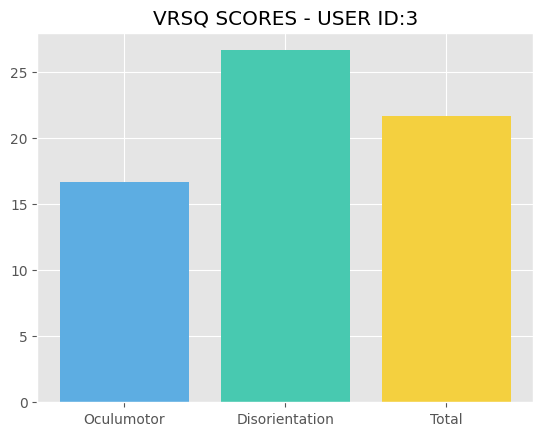

14
8.333333333333332 13.333333333333334 10.833333333333332


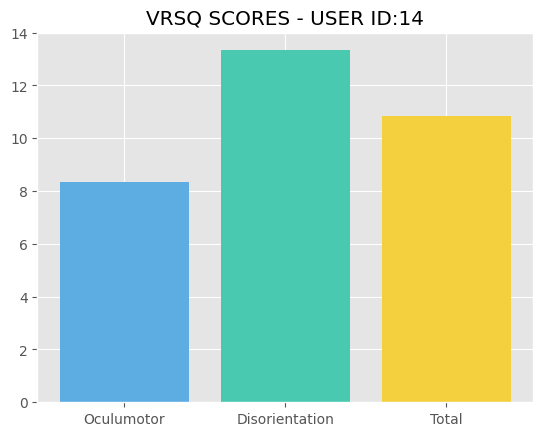

21
41.66666666666667 40.0 40.833333333333336


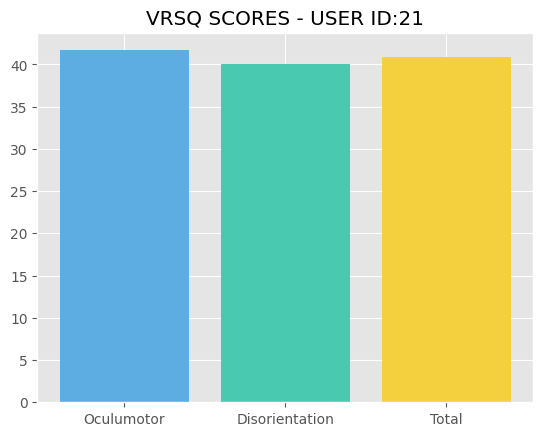

22
25.0 0.0 12.5


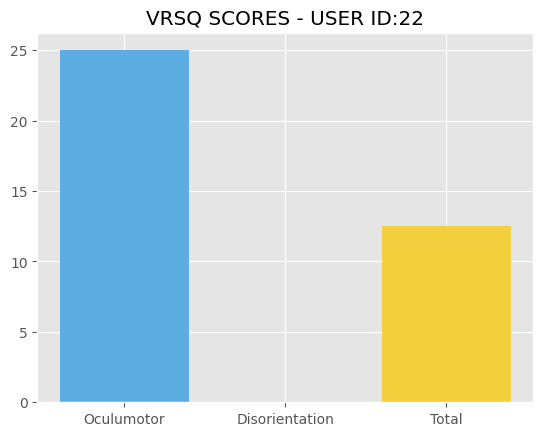

24
0.0 0.0 0.0


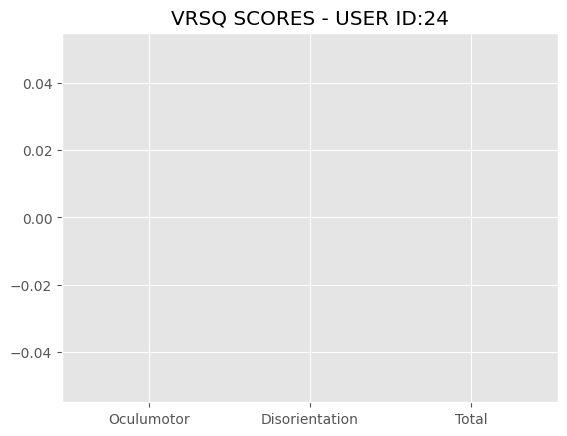

25
0.0 0.0 0.0


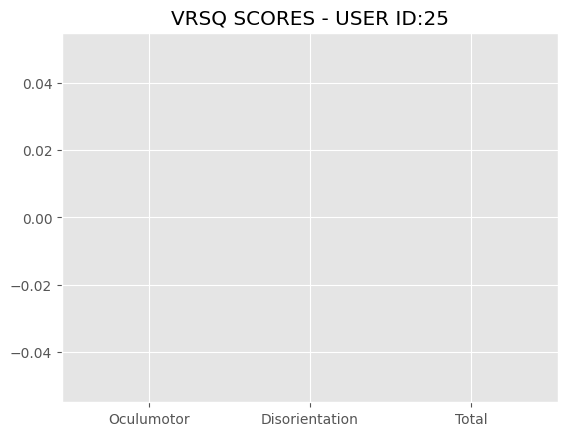

31
16.666666666666664 0.0 8.333333333333332


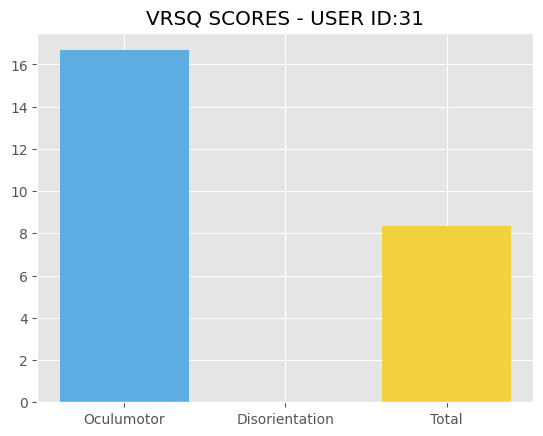

38
-16.666666666666686 13.333333333333332 -1.6666666666666767


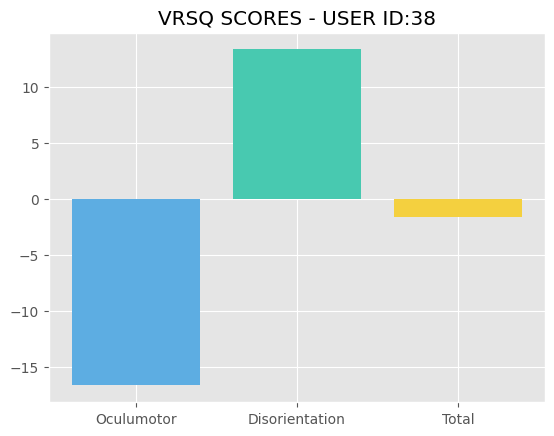

39
-8.333333333333332 6.666666666666667 -0.8333333333333326


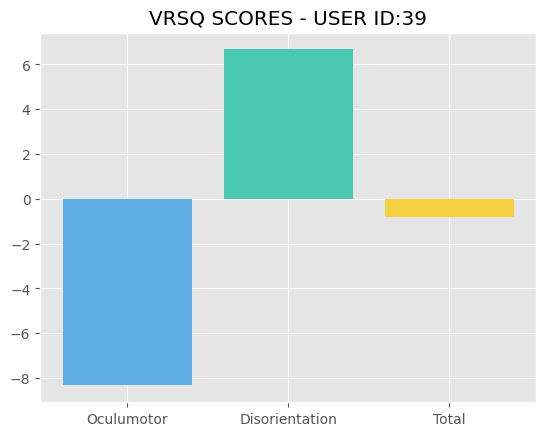

44
-8.333333333333332 0.0 -4.166666666666666


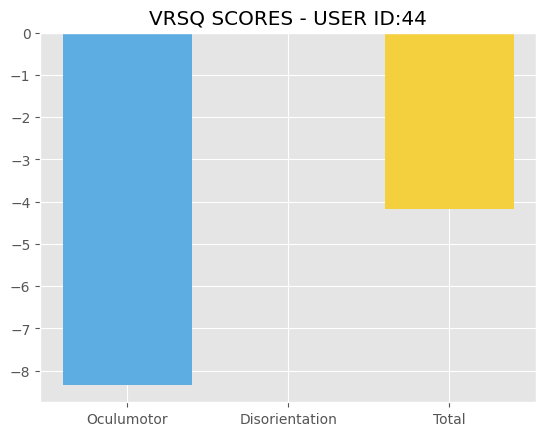

49
0.0 6.666666666666667 3.3333333333333335


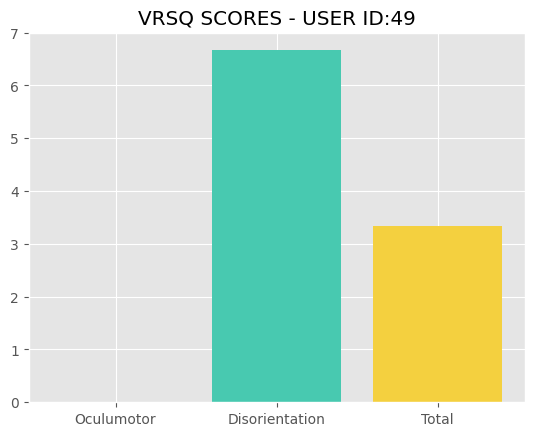

  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          1                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             1             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 0       0          0                  0        0   
1                 0       0          1                  0        0   

  FulnessOfHead BlurredVision DizzyEyesClosed Vertigo  
0             0             0               0       0  
1             1             0               0       0  
  GeneralDiscomfort Fatigue EyeStraing DifficultyFocusing Headache  \
0                 2       0          0                  0        0   
1                 2       0          0                  0        0   

  FulnessOfHead BlurredVision D

<ipython-input-15-ca59311e0b04>:273: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for row in range(dframe.count()[0]):


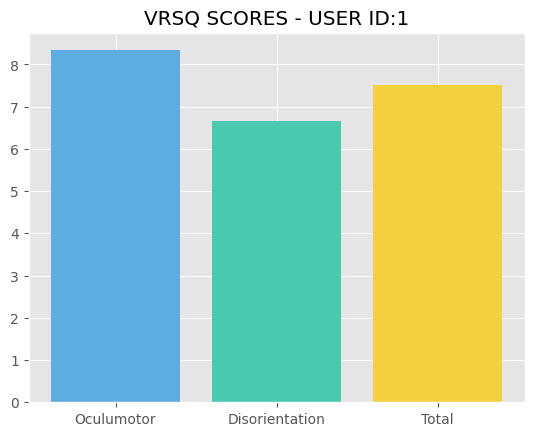

5
0.0 0.0 0.0


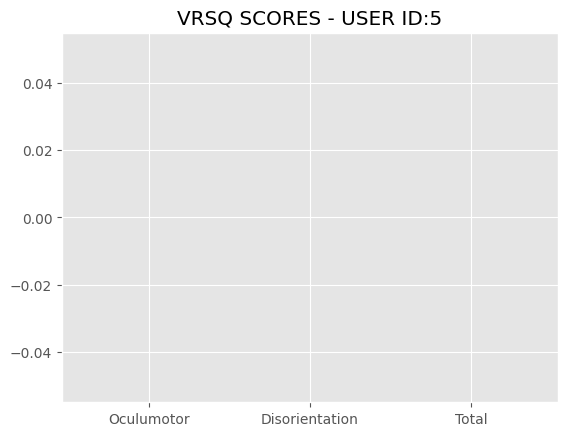

9
-8.333333333333336 0.0 -4.166666666666668


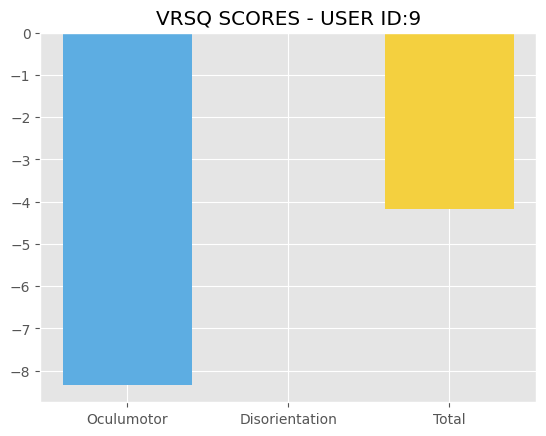

11
0.0 13.333333333333334 6.666666666666667


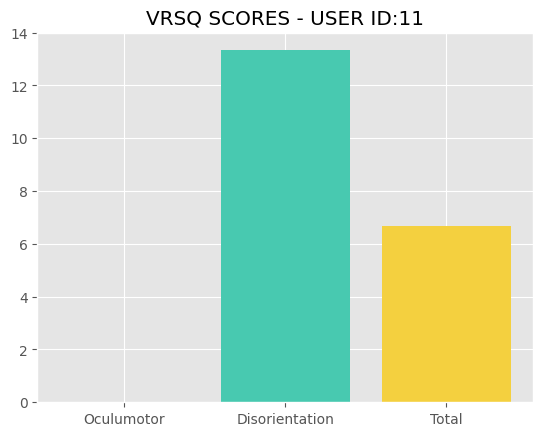

18
8.333333333333332 0.0 4.166666666666666


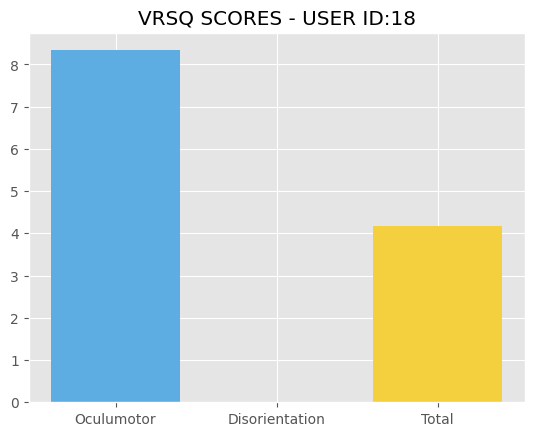

20
0.0 0.0 0.0


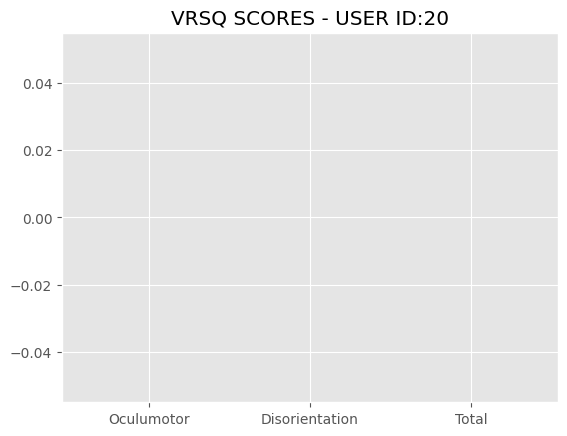

23
16.666666666666664 13.333333333333334 15.0


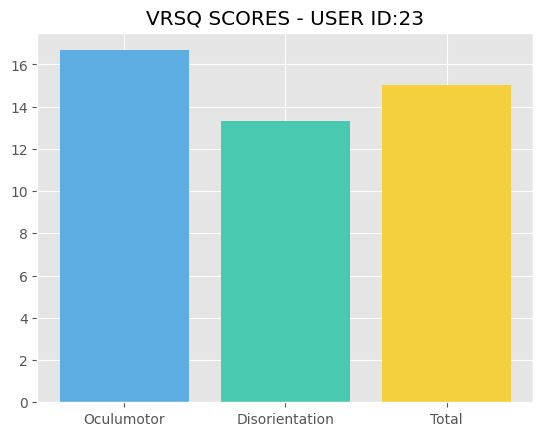

26
8.333333333333336 6.666666666666667 7.500000000000002


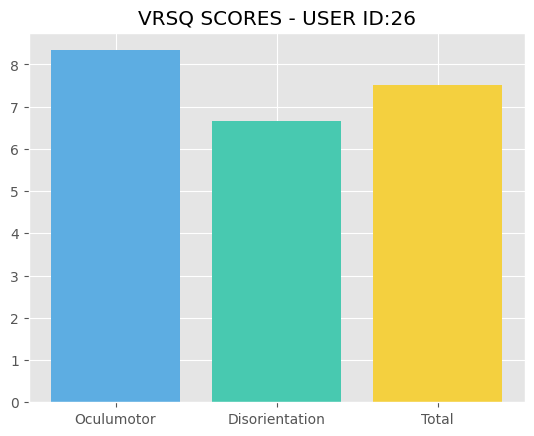

29
8.333333333333332 6.666666666666667 7.5


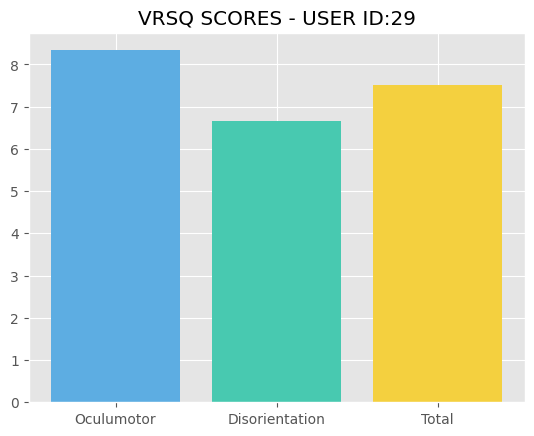

30
16.666666666666664 6.666666666666667 11.666666666666666


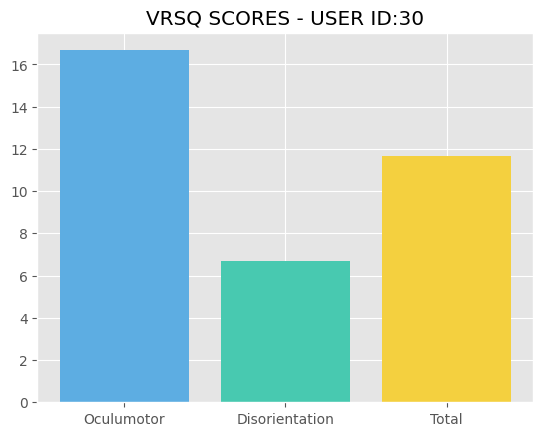

32
8.333333333333332 0.0 4.166666666666666


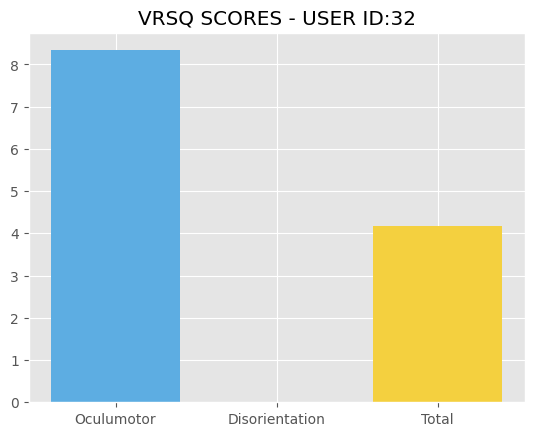

33
8.333333333333329 33.33333333333333 20.83333333333333


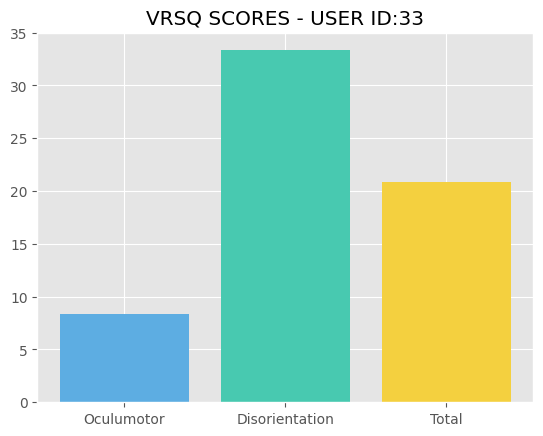

34
66.66666666666669 60.0 63.33333333333334


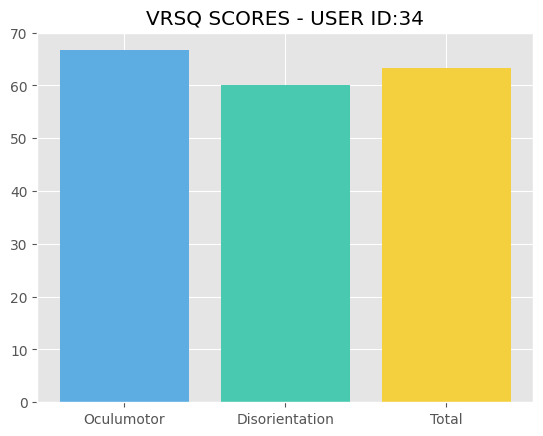

35
-8.333333333333332 0.0 -4.166666666666666


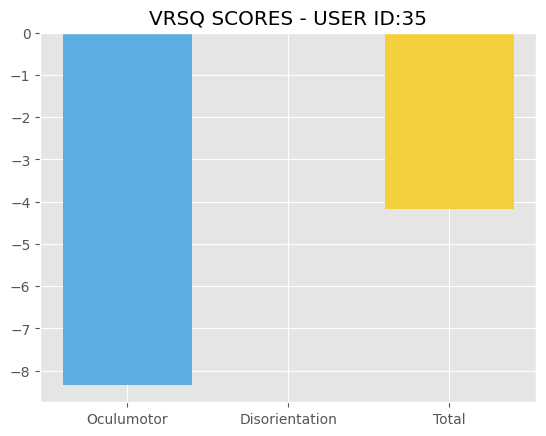

40
0.0 6.666666666666667 3.3333333333333335


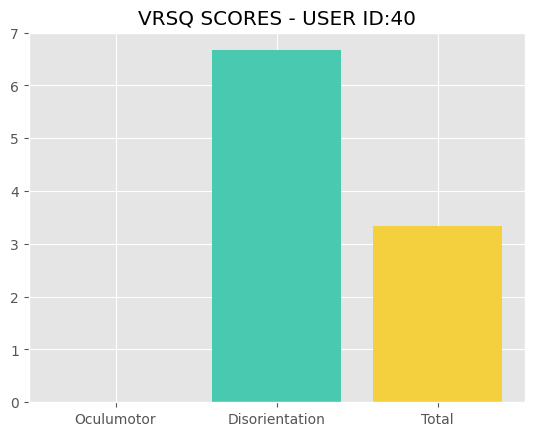

43
0.0 6.666666666666667 3.3333333333333335


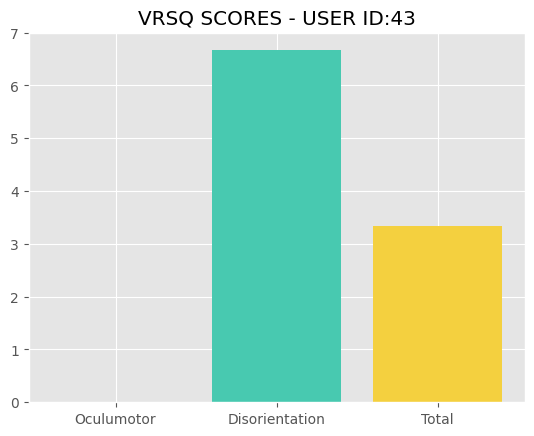

47
25.0 6.666666666666667 15.833333333333334


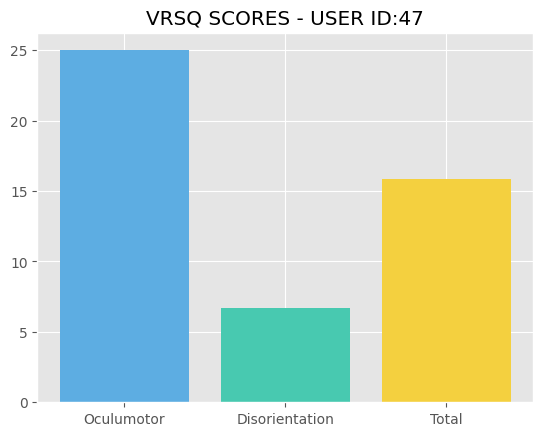

50
0.0 0.0 0.0


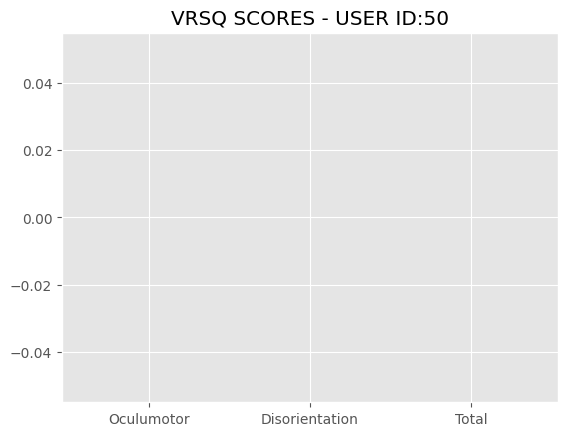

time: 19.4 s (started: 2024-11-29 23:27:18 +00:00)


In [ ]:
# database = '/content/DATABASE/DATABASE_VRSQ_CARRO/'
# users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
plotVRSQScores(dbRaceVRSQ, usersRace, 'A')

# database = '/content/DATABASE/DATABASE_VRSQ_PASSARO/'
# users = ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20']
plotVRSQScores(dbFlightVRSQ, usersFlight, 'B')

#plotVRSQScores(database, ['21'], 'B')

In [ ]:
vrsqA[0]   #Scenario A (Race)

oculumotor  disorientation      total
0    16.666667       26.666667  21.666667
1     8.333333       13.333333  10.833333
2    41.666667       40.000000  40.833333
3    25.000000        0.000000  12.500000
4     0.000000        0.000000   0.000000
5     0.000000        0.000000   0.000000
6    16.666667        0.000000   8.333333
7   -16.666667       13.333333  -1.666667
8    -8.333333        6.666667  -0.833333
9    -8.333333        0.000000  -4.166667
10    0.000000        6.666667   3.333333

time: 24.6 ms (started: 2024-11-29 23:27:45 +00:00)


In [ ]:
vrsqB[0]   #Scenario B (Flight)

oculumotor  disorientation      total
0     8.333333        6.666667   7.500000
1     0.000000        0.000000   0.000000
2    -8.333333        0.000000  -4.166667
3     0.000000       13.333333   6.666667
4     8.333333        0.000000   4.166667
5     0.000000        0.000000   0.000000
6    16.666667       13.333333  15.000000
7     8.333333        6.666667   7.500000
8     8.333333        6.666667   7.500000
9    16.666667        6.666667  11.666667
10    8.333333        0.000000   4.166667
11    8.333333       33.333333  20.833333
12   66.666667       60.000000  63.333333
13   -8.333333        0.000000  -4.166667
14    0.000000        6.666667   3.333333
15    0.000000        6.666667   3.333333
16   25.000000        6.666667  15.833333
17    0.000000        0.000000   0.000000

time: 17.8 ms (started: 2024-11-29 23:27:51 +00:00)


## 2. Execucao de LeaveOneOut Adaptado - RandomForest

In [ ]:
def show_AllRFResultsToDF(users,aucScores,d):
    depth_list = []
    auc_train =[]
    auc_test = []
    for auc in aucScores:
        auc_train.append(auc[0])
        auc_test.append(auc[1])
    for i in range(len(users)):
        depth_list.append(d)

    print(auc_train)

    df1 = pd.DataFrame(users, columns=['User ID'])
    df2 = pd.DataFrame(depth_list, columns=['Depth'])
    df3 = pd.DataFrame(auc_train, columns=['Auc Train'])
    df4 = pd.DataFrame(auc_test, columns=['Auc Test'])
    dfresult =  pd.concat([df1,df2,df3,df4], axis=1, join='inner')
    return dfresult

time: 1.18 ms (started: 2024-11-29 23:28:12 +00:00)


In [ ]:
print("LeaveOneOut Flight")
# database = '/content/DATABASE/DATABASE_PASSARO/'
# users = ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#models = RFLeaveOneOutUser(database,7, users, featureOut, True, True,True)
print("------------------")

df_col_rf_flight = []

for d in range(7,15):
    results = RFLeaveOneOutUser(dbFlightGAME, d, usersFlight, featureOut, True, True, True)
    rf_flight_model = results[0]
    aucScores = results[1]
    df_col_rf_flight.append(show_AllRFResultsToDF(usersFlight, aucScores, d))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(df_col_rf_flight)):
    x = df_col_rf_flight[i]['Auc Train'].mean()
    y = df_col_rf_flight[i]['Auc Test'].mean()
    print(i, y, abs(x-y))

df_col_rf_flight[0].style.hide()

0 0.7926444092917618 0.13654092392914674
1 0.7749403988696817 0.1680161965379382
2 0.7820349729726267 0.17216654486720817
3 0.773086997388856 0.1912351240698289
4 0.7696680101053072 0.2051537959794838
5 0.7587274949119611 0.22460842410186266
6 0.7532842693001961 0.23695556875791057
7 0.7491170706167303 0.24574665234162074


time: 120 ms (started: 2024-11-29 23:42:25 +00:00)


In [ ]:
#LeaveOneOut tests
print("LeaveOneOut Car")
# database = '/content/DATABASE/DATABASE_CARRO/'
# users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
# features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#models_car = RFLeaveOneOutUser(database, users, featureOut, True, True)
print("------------------")

df_col_rf_car = []

for d in range(7,15):
    results = RFLeaveOneOutUser(dbRaceGAME, d, usersRace, featureOut, True, True, True)
    aucScores = results[1]
    df_col_rf_car.append(show_AllRFResultsToDF(usersRace, aucScores, d))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(df_col_rf_car)):
    x = df_col_rf_car[i]['Auc Train'].mean()
    y = df_col_rf_car[i]['Auc Test'].mean()
    print(i, y, abs(x-y))

df_col_rf_car[0].style.hide()

0 0.5535465653711841 0.3627003531630847
1 0.584251071108884 0.3505428254341424
2 0.585424821839066 0.3687232814349073
3 0.5887138390002148 0.3807926073574611
4 0.5999639091830521 0.381994923450911
5 0.6065896395993886 0.38302326955924626
6 0.6104909336864079 0.3848268392510248
7 0.6201086492461484 0.3775910176053515


time: 18.9 ms (started: 2024-11-29 23:47:51 +00:00)


# 3. Execucao LeaveOneOut Adaptado - Decision Tree

In [ ]:
def show_MinLeafsAndAucScoreResults(users,minLeafsValues,aucScores):
    depth_list = []
    auc_train =[]
    auc_test = []
    minValues = []
    for auc in aucScores:
        auc_train.append(auc[0])
        auc_test.append(auc[1])
    for i in range(len(users)):
        depth_list.append(d)
    for m in minLeafsValues:
        minValues.append(m)
    df1 = pd.DataFrame(users, columns=['User ID'])
    df2 = pd.DataFrame(depth_list, columns=['Depth'])
    df3 = pd.DataFrame(minValues, columns=['MinLeavesValue'])
    df4 = pd.DataFrame(auc_train, columns=['Auc Train'])
    df5 = pd.DataFrame(auc_test, columns=['Auc Test'])
    dfresult =  pd.concat([df1,df2,df3,df4,df5], axis=1, join='inner')
    return dfresult

time: 873 µs (started: 2024-11-29 23:47:54 +00:00)


In [ ]:
#LeaveOneOut tests
print("LeaveOneOut Flight")
# database = '/content/DATABASE/DATABASE_PASSARO/'
# users = ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
#dt_models_flight = LeaveOneOutUser(database, users, featureOut,7, True, True,False)

dt_models_flight = []
df_col = []
#d = 10
for d in range(7,15):
    results = LeaveOneOutUser(dbFlightGAME, usersFlight, featureOut, d, True, True, False, True)
    minLeafsValues = results[1]
    aucScores = results[2]
    dt_models_flight.append(results[0])
    df_col.append(show_MinLeafsAndAucScoreResults(usersFlight,minLeafsValues,aucScores))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(df_col)):
    x = df_col[i]['Auc Train'].mean()
    y = df_col[i]['Auc Test'].mean()
    print(i, y, abs(x-y))

df_col[0].style.hide()

0 0.7225842030786422 0.21601437252353295
1 0.6706138039675316 0.2830397290638538
2 0.6629084949998051 0.30151100941597264
3 0.669479231064726 0.3068787459289789
4 0.6342327334027263 0.34908323902877947
5 0.6567379814269728 0.3343177832423895
6 0.6330688543727777 0.36153487427942665
7 0.6419269843757038 0.3552698219307795


time: 22.3 ms (started: 2024-11-29 23:55:45 +00:00)


In [ ]:
print("LeaveOneOut CAR")
#LeaveOneOut tests
# database = '/content/DATABASE/DATABASE_CARRO/'
# users = ['21','22','23','24','25','26','27','28', '29','30','31','32','33','34','35']
features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featureOut = []
dt_models_car = []

df_col_car = []
for d in range(7,15):
    results = LeaveOneOutUser(dbRaceGAME, usersRace, featureOut, d, True, True, False, True)
    minLeafsValues = results[1]
    aucScores = results[2]
    dt_models_car.append(results[0])
    df_col_car.append(show_MinLeafsAndAucScoreResults(usersRace,minLeafsValues,aucScores))
print("------------------")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(df_col_car)):
    x = df_col_car[i]['Auc Train'].mean()
    y = df_col_car[i]['Auc Test'].mean()
    print(i, y, abs(x-y))

df_col_car[0].style.hide()

0 0.5830909143309099 0.28424655198181914
1 0.5470460226738467 0.33860522343649135
2 0.5394720949939943 0.36861170942894594
3 0.565593271952831 0.35729215481643617
4 0.5596070388519414 0.3803330653984197
5 0.552022821665372 0.3994381082149244
6 0.5651294823916243 0.4021966837136183
7 0.5357725226010732 0.437758442476449


time: 21 ms (started: 2024-11-29 23:59:40 +00:00)


In [ ]:
#Este teste, me mostra o desconforto predito em cada instancia e a lista de causas associadas naquela instancia
#Gero um dataframe final com a timeline da experiencia de jogo
#Retiro do conjunto de teste o usuario que ira fazer parte do Teste
#dtModel
def PredictDiscomfortAndCausesFromUserOutTrainingRF(_database, user, _depth, featuresOut):
    # Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
    # Set it None to display all rows in the dataframe
    pd.set_option('display.max_rows', None)

    result = parseXmlDirToDataFrame(_database,[user])
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    raw_df_out = df_out
    depth = _depth
    #Pre process dataset
    df = PreProcessDataFrame(df,featuresOut) #['TimeStamp']
    df = oversampling(df)
    attributes = df.columns[:-1]
    df_out = PreProcessDataFrame(df_out,featuresOut)

    results = RFTrainingProcessWithReport(_database,featuresOut,[user],depth,True)
    #c_report = GetCustomReportAccF1Auc(results)

    dtModel = results[0]

    #prediction
    r = predict_discomfort_rf(df_out,results[0],attributes.values,False)
    #causes = r[0]
    raw_pred = r[2]
    raw_causes = r[3]
    causes_node_depth = r[1]
    dfpred = pd.DataFrame(raw_pred, columns=['prediction ' + user ])
    dfreal = pd.DataFrame(raw_df_out['DiscomfortLevel'].values.tolist(), columns=['real ' + user])
    dftime = pd.DataFrame(raw_df_out['TimeStamp'].values.tolist(), columns=['TimeStamp'])
    #dfcauses = pd.DataFrame(raw_causes,columns=['causes'])
    #dfNodeDepths = pd.DataFrame(raw_nodes_depth,columns=['Feature','NodeDepth'])

    causes_array = []
    node_depth_array = []
    for item in causes_node_depth:
        causes_array.append(item[0])
        node_depth_array.append(item[1])
        #print (str(item[0]) + ' ' + str(item[1]))

    #vou precisar agora calcular novamente a frequencia das causas com os pesos e  normalizar
    fn = []
    #print(len(causes))
    #print(len(causes_array))

    if (len(causes_array) > 0):
        plot_causes_graph(calculate_causes_feqweighted(causes_array,node_depth_array),user, True)
        #ranking = calculate_causes_feqweighted(causes_array,node_depth_array)
    dfresult =  pd.concat([dftime,dfpred, dfreal], axis=1, join='inner')
    return dfresult

time: 1.27 ms (started: 2024-11-29 23:59:44 +00:00)


# 3.1 Testes com o melhor modelo gerado pelo LOO por Decision Tree e plotagem das causas

Predicao de causas com plot jogo do passaro de todos os usuarios

In [ ]:
#Este teste, me mostra o desconforto predito em cada instancia e a lista de causas associadas naquela instancia
#Gero um dataframe final com a timeline da experiencia de jogo
#Retiro do conjunto de teste o usuario que ira fazer parte do Teste
#dtModel
def PredictDiscomfortAndCausesFromUserOutTraining(_database, user, _depth, featuresOut):
    # Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
    # Set it None to display all rows in the dataframe
    pd.set_option('display.max_rows', None)

    result = parseXmlDirToDataFrame(_database,[user])
    df = result[0]
    in_training = result[1]
    out_training = result[2]
    df_out = result[3]
    raw_df_out = df_out
    depth = _depth
    #Pre process dataset
    df = PreProcessDataFrame(df,featuresOut) #['TimeStamp']
    df = oversampling(df)
    attributes = df.columns[:-1]
    df_out = PreProcessDataFrame(df_out,featuresOut)

    results = TrainingProcessWithReport(_database,featuresOut,[user],depth,True,False)
    c_report = GetCustomReportAccF1Auc(results)

    dtModel = results[0]

    #prediction
    r = predict_discomfort(df_out,results[0],attributes.values,False)
    causes = r[0]
    raw_pred = r[4]
    raw_causes = r[5]
    causes_node_depth = r[6]
    dfpred = pd.DataFrame(raw_pred, columns=['prediction ' + user ])
    dfreal = pd.DataFrame(raw_df_out['DiscomfortLevel'].values.tolist(), columns=['real ' + user])
    dftime = pd.DataFrame(raw_df_out['TimeStamp'].values.tolist(), columns=['TimeStamp'])
    #dfcauses = pd.DataFrame(raw_causes,columns=['causes'])
    #dfNodeDepths = pd.DataFrame(raw_nodes_depth,columns=['Feature','NodeDepth'])

    causes_array = []
    node_depth_array = []
    for item in causes_node_depth:
        causes_array.append(item[0])
        node_depth_array.append(item[1])
        #print (str(item[0]) + ' ' + str(item[1]))

    #vou precisar agora calcular novamente a frequencia das causas com os pesos e  normalizar
    fn = []
    #print(len(causes))
    #print(len(causes_array))

    if (len(causes_array) > 0):
        plot_causes_graph(calculate_causes_feqweighted(causes_array,node_depth_array),user, True)
        #ranking = calculate_causes_feqweighted(causes_array,node_depth_array)
    dfresult =  pd.concat([dfpred, dfreal], axis=1, join='inner')
    return dfresult

time: 1.27 ms (started: 2024-11-29 23:59:47 +00:00)


03
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  303
X_train = 4346 , X_test =  303 , y_train = 4346 , y_test = 303 , y_pred = 303
Depth: 13
Minimum Leaf Sample:4
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['14', '21', '22', '24', '25', '31', '38', '39', '44', '49']
              precision    recall  f1-score   support

           0       0.26      1.00      0.42        35
           1       1.00      0.63      0.78       268

    accuracy                           0.68       303
   macro avg       0.63      0.82      0.60       303
weighted avg       0.91      0.68      0.73       303

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserExperience', 'UserGenere']
[19.77, 0.99, 1.06, 11.68, 41.08, 13.26, 12.16]
14
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  303
X_train = 4014

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  274
X_train = 4090 , X_test =  274 , y_train = 4090 , y_test = 274 , y_pred = 274
Depth: 13
Minimum Leaf Sample:6
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['03', '14', '22', '24', '25', '31', '38', '39', '44', '49']
              precision    recall  f1-score   support

           0       0.55      0.53      0.54       163
           1       0.35      0.38      0.37       111

    accuracy                           0.47       274
   macro avg       0.45      0.45      0.45       274
weighted avg       0.47      0.47      0.47       274

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[18.36, 0.6, 1.8, 13.4, 27.75, 14.37, 13.27, 10.44]
22
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[17.13, 0.82, 3.69, 6.57, 33.46, 14.48, 13.36, 10.5]
24
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_train = 3908 , X_test =  302 , y_train = 3908 , y_test = 302 , y_pred = 302
Depth: 13
Minimum Leaf Sample:3
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['03', '14', '21', '22', '25', '31', '38', '39', '44', '49']
              precision    recall  f1-score   support

           0       0.85      0.58      0.69       254
           1       0.17      0.44      0.24        48

    accuracy                           0.56       302
   macro avg       0.51      0.51      0.46       302
weighted avg       0.74      0.56      0.62       302

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp',

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[22.17, 0.83, 3.48, 11.25, 23.73, 14.32, 13.21, 11.01]
44
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  302
X_train = 3812 , X_test =  302 , y_train = 3812 , y_test = 302 , y_pred = 302
Depth: 13
Minimum Leaf Sample:3
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['03', '14', '21', '22', '24', '25', '31', '38', '39', '49']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       302
           1       0.00      0.00      0.00         0

    accuracy                           0.59       302
   macro avg       0.50      0.29      0.37       302
weighted avg       1.00      0.59      0.74       302

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserGenere']
[20.56, 2.39, 2.74, 16.53, 31.67, 14.3, 11.81]
49
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  303
X_train = 3810 , X_test =  303 , y_train = 3810 , y_test = 303 , y_pred = 303
Depth: 13
Minimum Leaf Sample:12
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['03', '14', '21', '22', '24', '25', '31', '38', '39', '44']
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[1.92, 9.65, 0.65, 2.08, 39.02, 18.4, 16.98, 11.3]


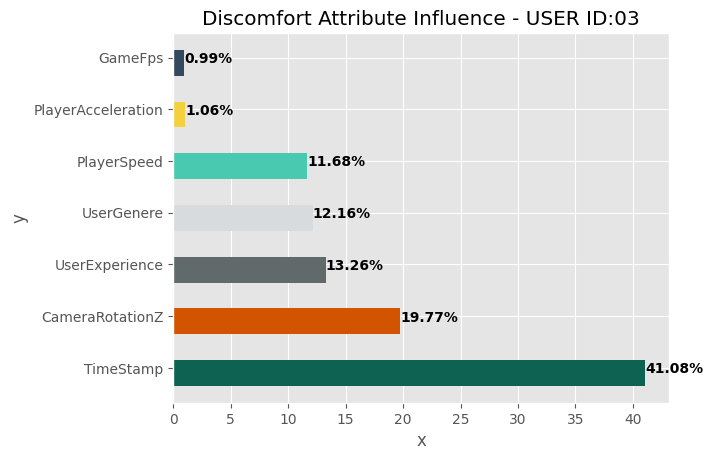

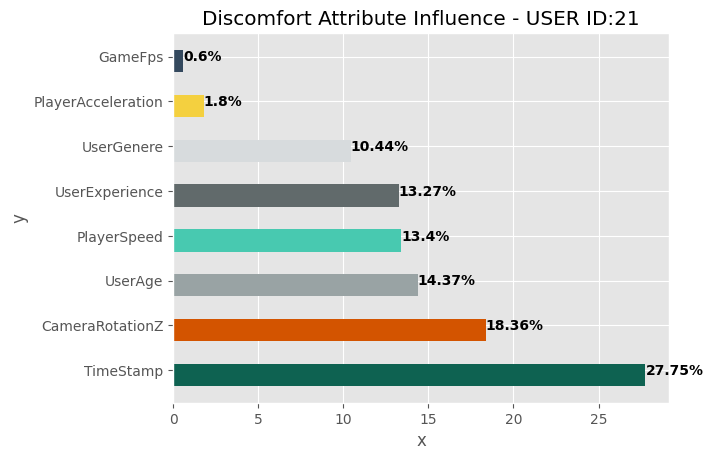

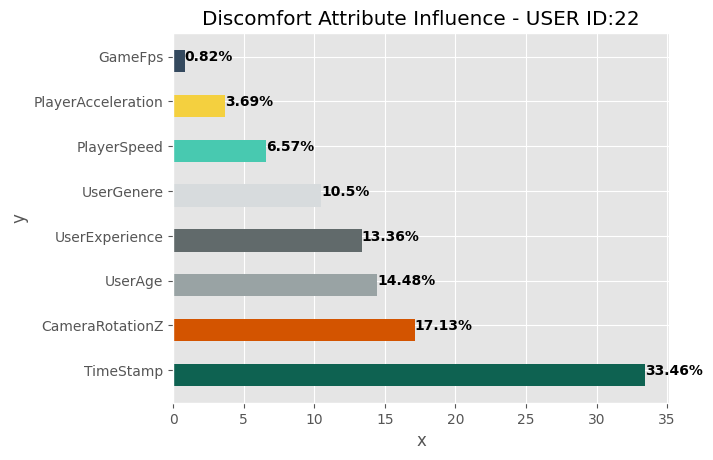

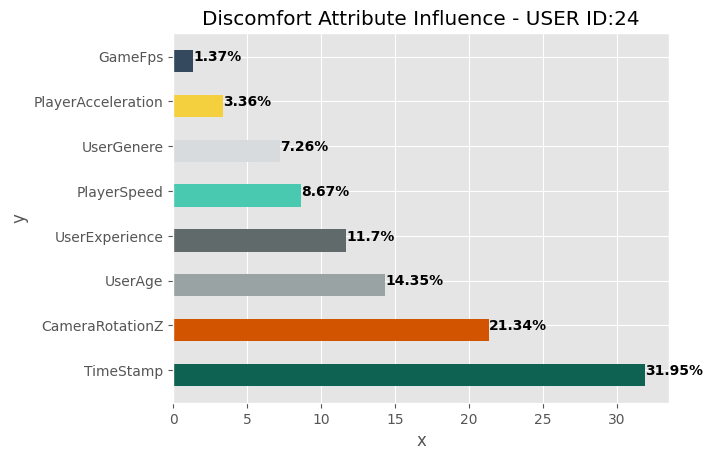

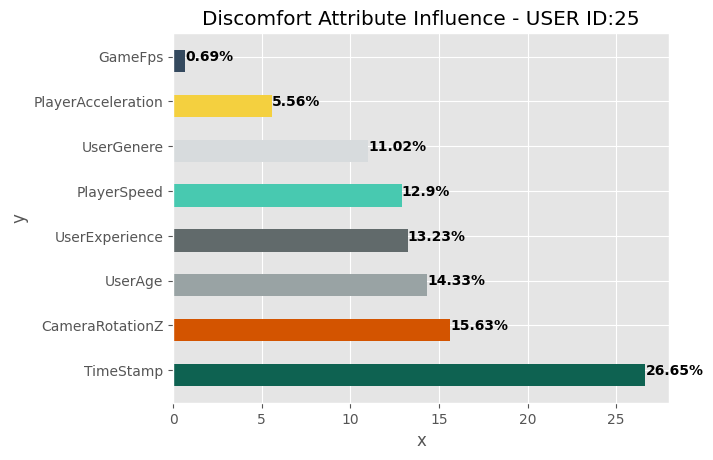

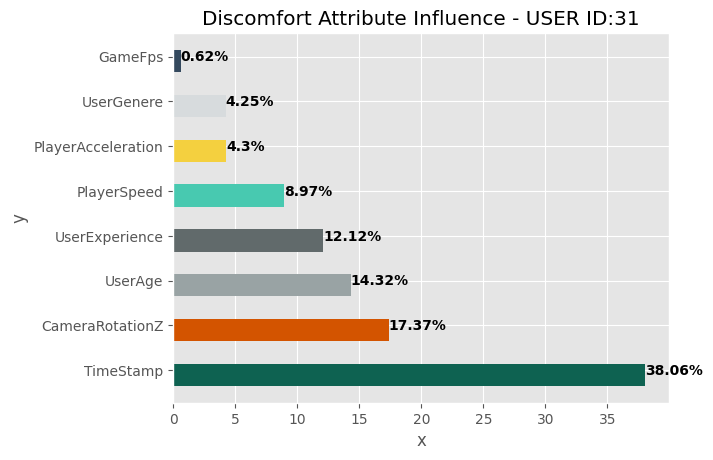

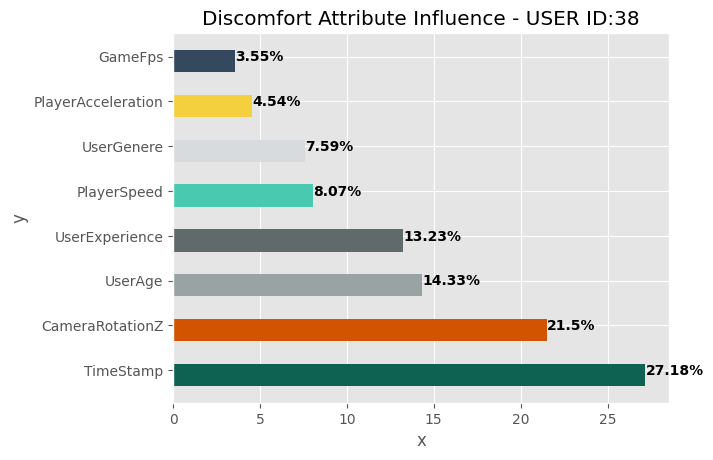

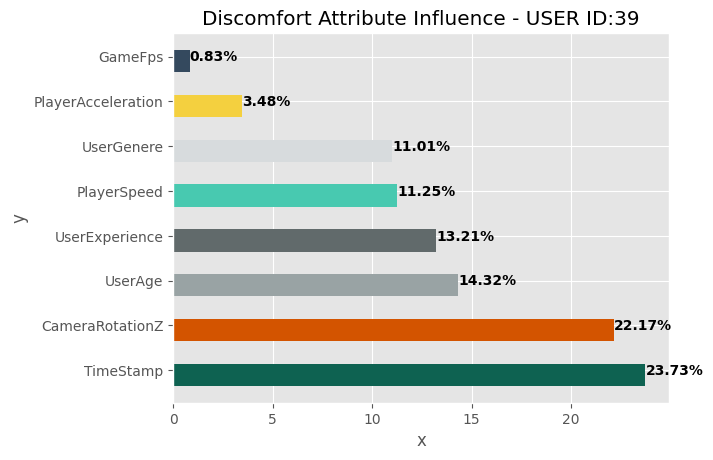

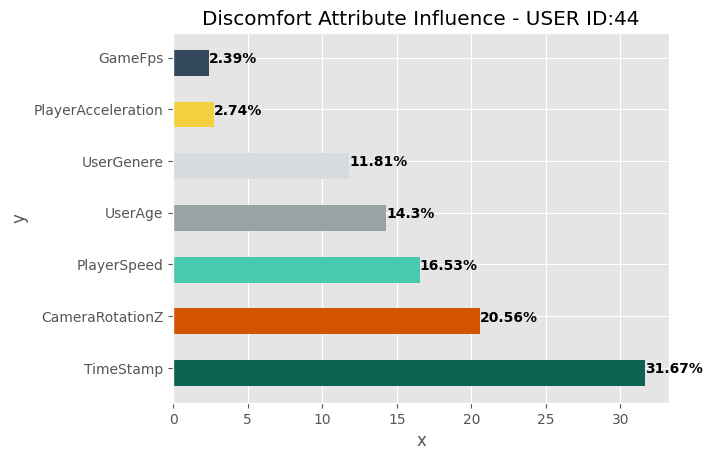

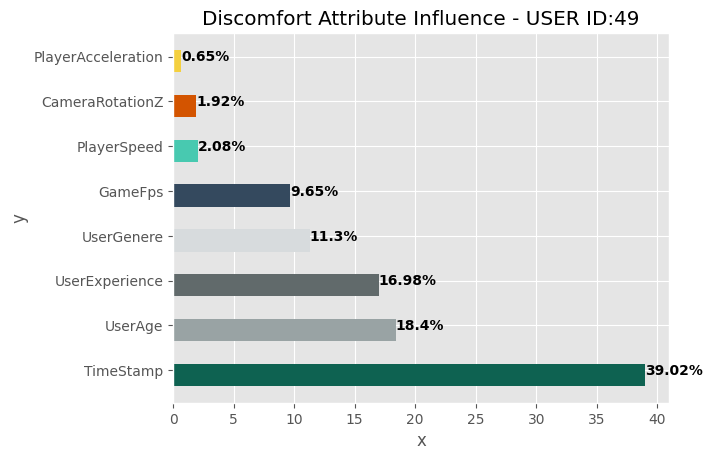

time: 33.8 s (started: 2024-11-29 23:59:54 +00:00)


In [ ]:
#Decision Teste sem usar LeaveOneOut
# databaseA = '/content/DATABASE/DATABASE_CARRO/'
databaseA = dbRaceGAME


# PREDICAO JOGO DO CARRO - PREDICAO DE DESCONFORTO PARA USUARIOS
# TestUsersA =  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
TestUsersA = usersRace
A = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userA in TestUsersA:
    print(userA)
    r = PredictDiscomfortAndCausesFromUserOutTraining(databaseA, userA, 13, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    A.append(r)

01
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  303
X_train = 5146 , X_test =  303 , y_train = 5146 , y_test = 303 , y_pred = 303
Depth: 9
Minimum Leaf Sample:7
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['05', '09', '11', '18', '20', '23', '26', '29', '30', '32', '33', '34', '35', '40', '43', '47', '50']
              precision    recall  f1-score   support

           0       0.92      0.54      0.68       285
           1       0.03      0.22      0.05        18

    accuracy                           0.52       303
   macro avg       0.47      0.38      0.36       303
weighted avg       0.86      0.52      0.64       303

['CameraRotationZ', 'GameFps', 'PlayerAcceleration', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[36.86, 0.75, 0.52, 13.03, 30.61, 0.79, 14.88, 2.57]
05
User Adapt LeaveOneOut - Train:100% 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

              precision    recall  f1-score   support

           0       1.00      0.54      0.70       303
           1       0.00      0.00      0.00         0

    accuracy                           0.54       303
   macro avg       0.50      0.27      0.35       303
weighted avg       1.00      0.54      0.70       303

['CameraRotationZ', 'GameFps', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience', 'UserGenere']
[24.78, 7.53, 16.82, 40.01, 1.55, 0.44, 8.87]
40
User Adapt LeaveOneOut - Train:100% A, Test:100% B
number instances (B) =  303
X_train = 5418 , X_test =  303 , y_train = 5418 , y_test = 303 , y_pred = 303
Depth: 9
Minimum Leaf Sample:7
in training(fn):  ['UserGenere', 'UserAge', 'UserExperience', 'TimeStamp', 'PlayerSpeed', 'PlayerAcceleration', 'CameraRotationZ', 'GameFps']
in training(users):  ['01', '05', '09', '11', '18', '20', '23', '26', '29', '30', '32', '33', '34', '35', '43', '47', '50']
              precision    recall  f1-score   support

           0 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

['CameraRotationZ', 'GameFps', 'PlayerSpeed', 'TimeStamp', 'UserAge', 'UserExperience']
[43.46, 6.14, 2.07, 47.84, 0.28, 0.21]


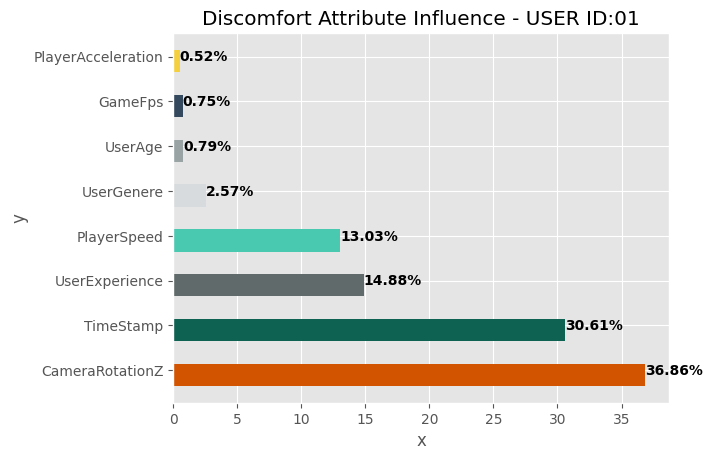

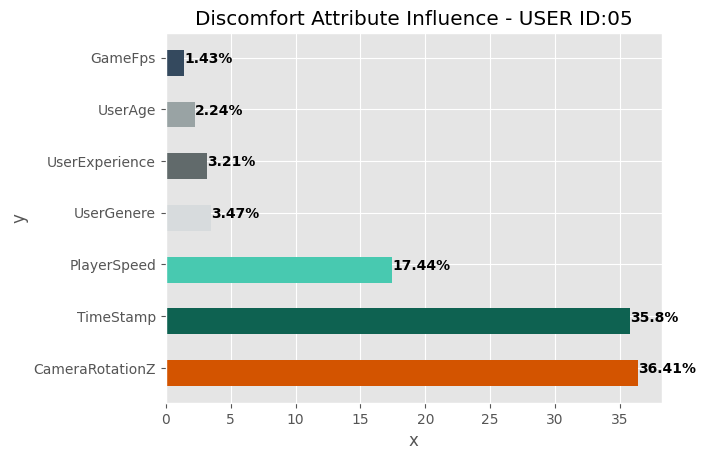

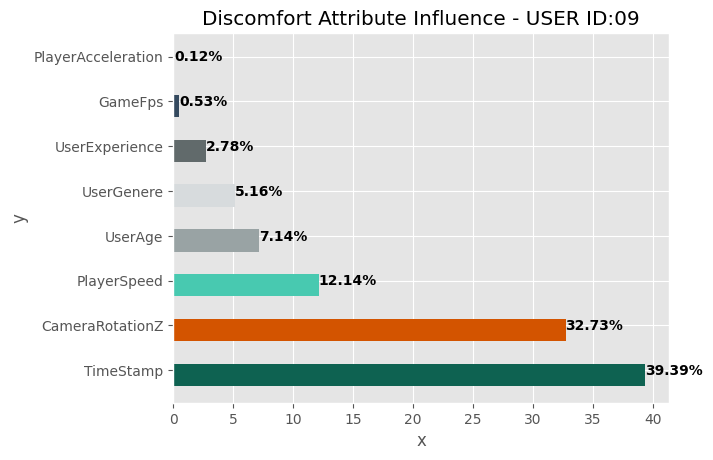

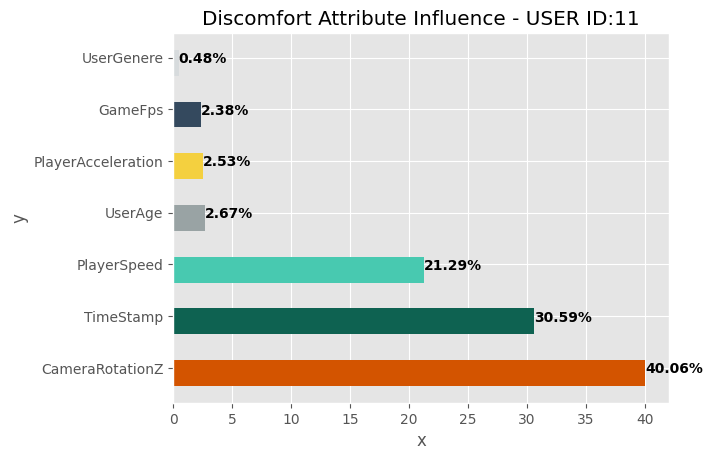

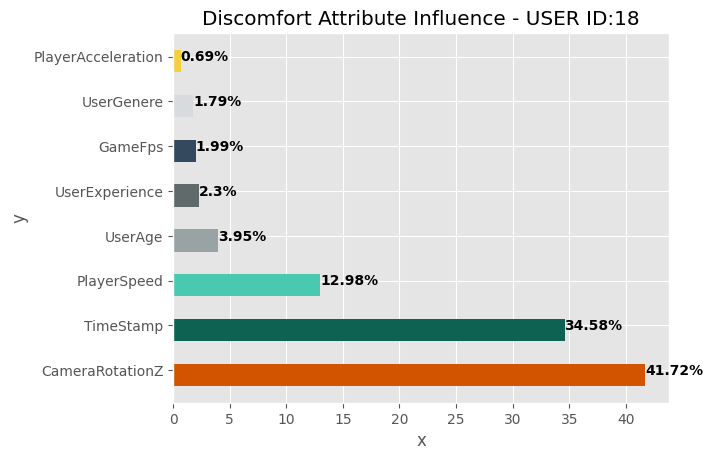

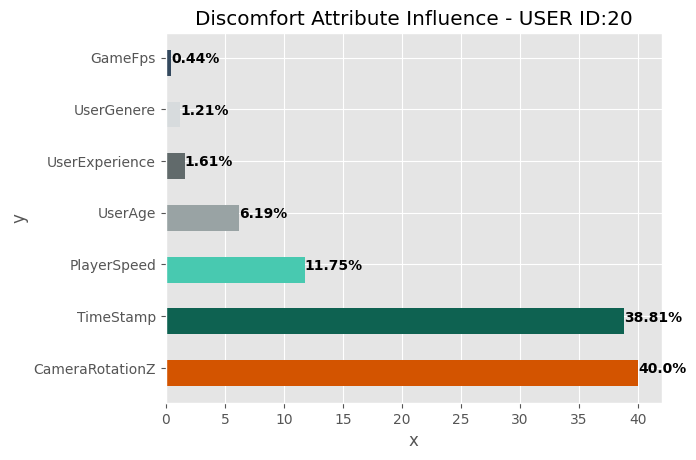

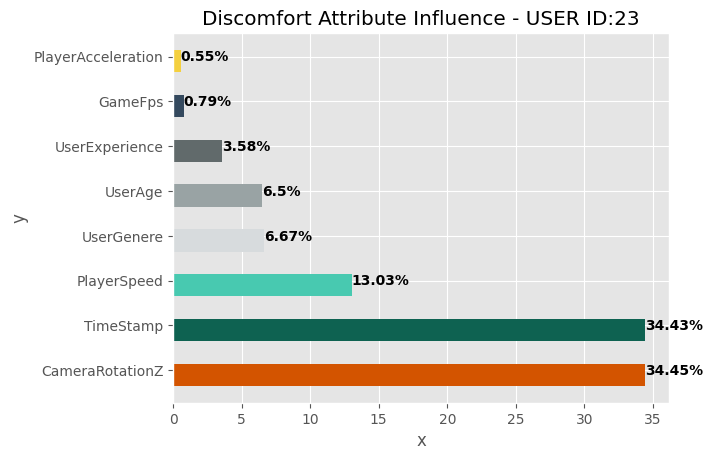

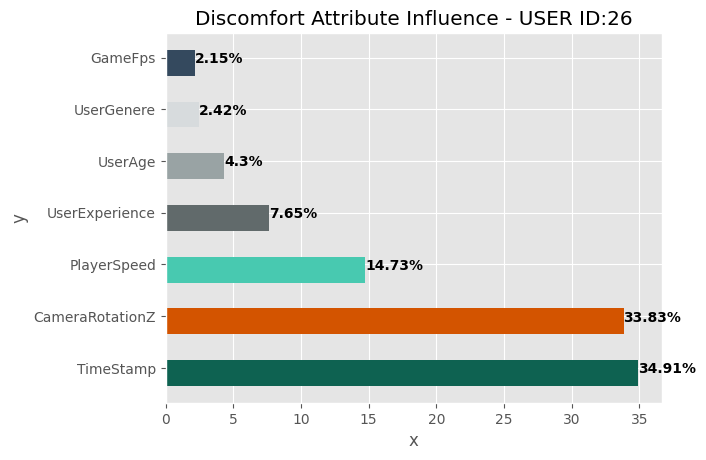

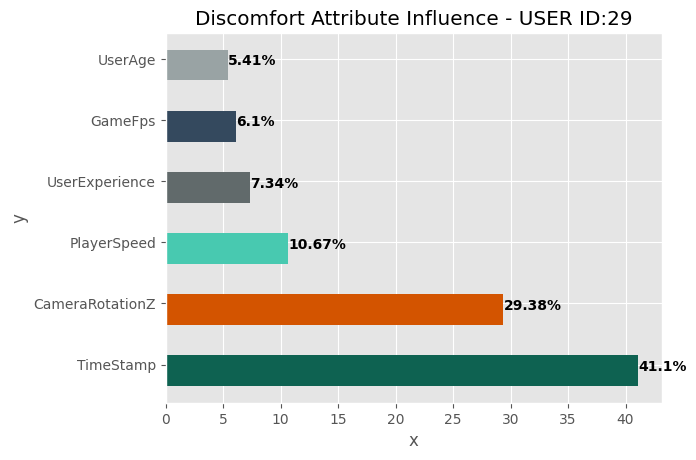

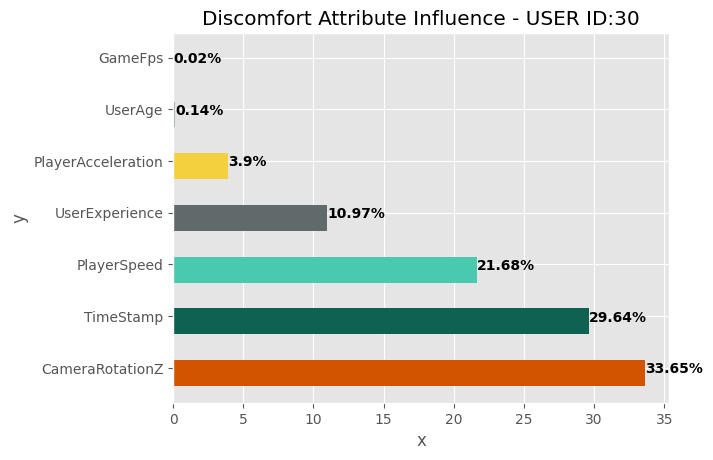

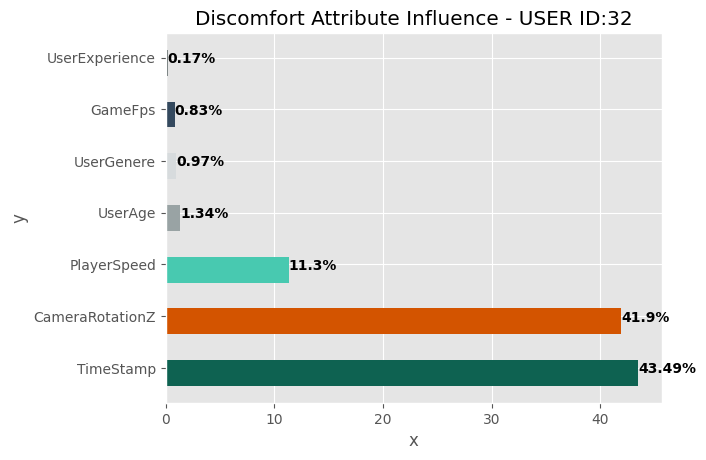

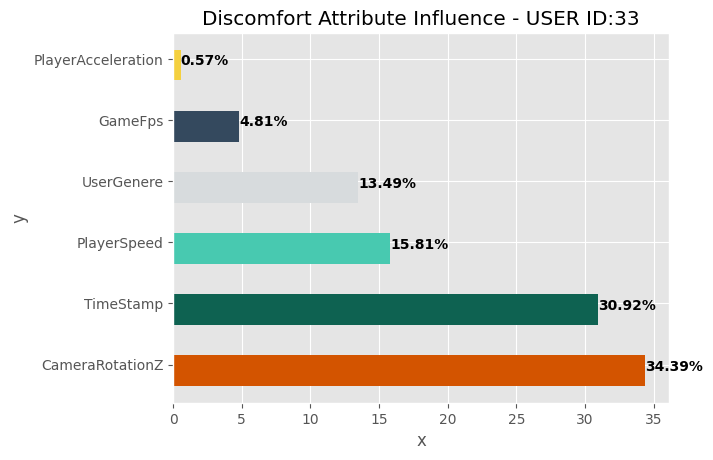

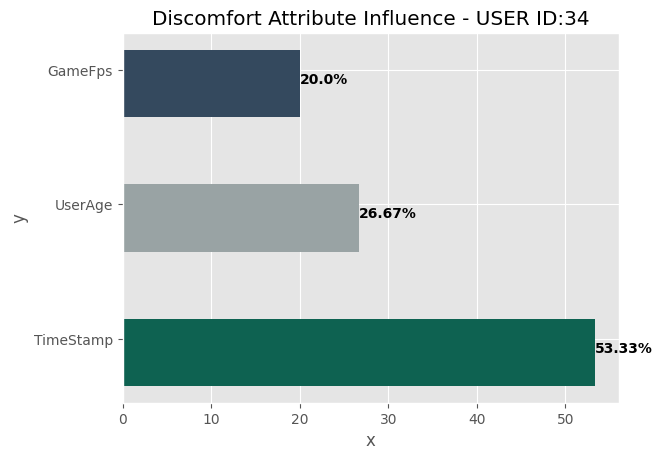

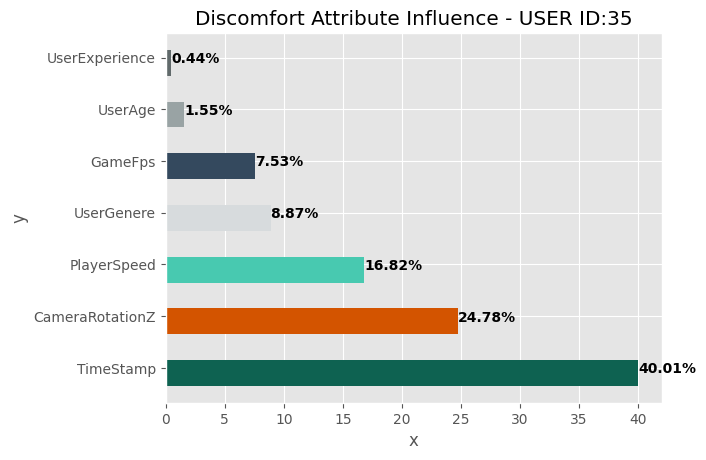

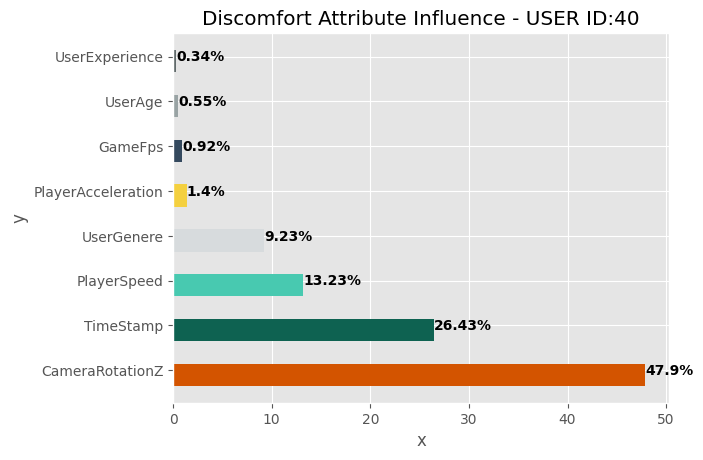

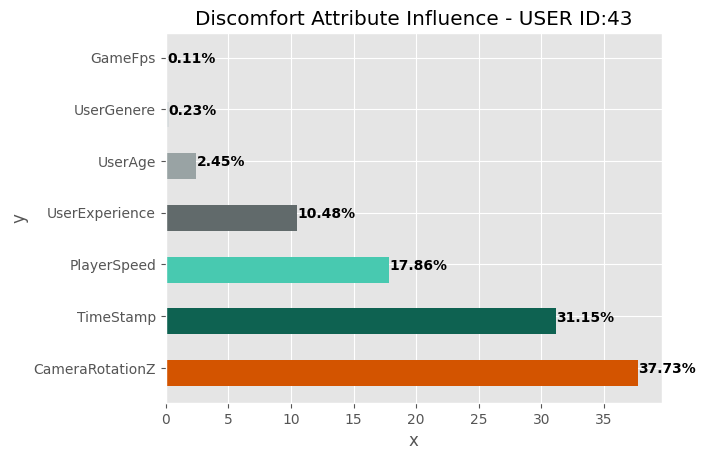

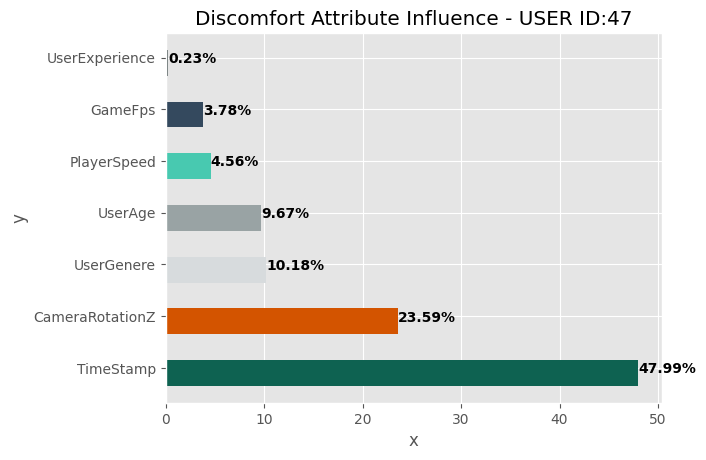

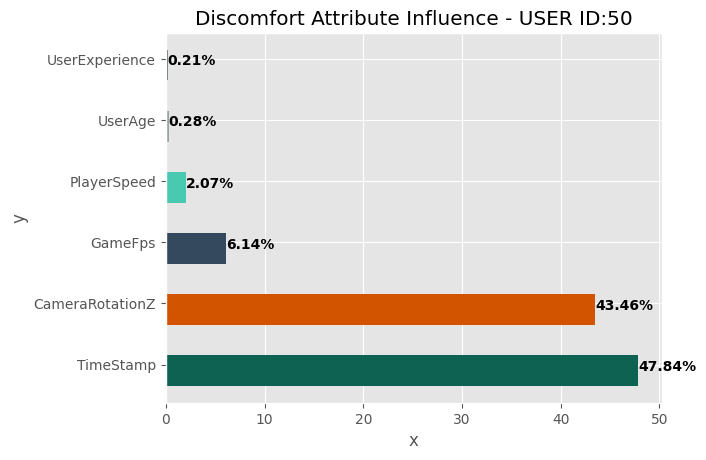

time: 1min 33s (started: 2024-11-30 00:01:34 +00:00)


In [ ]:
# databaseB = '/content/DATABASE/DATABASE_PASSARO/'
databaseB = dbFlightGAME

# PREDICAO JOGO DO PASSARO - PREDICAO DE DESCONFORTO PARA USUARIOS
# TestUsersB =  ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20']
TestUsersB = usersFlight
B = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userB in TestUsersB:
    print(userB)
    PredictDiscomfortAndCausesFromUserOutTraining(databaseB, userB, 9, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    B.append(r)

# RF PREEICTION

A saída de streaming foi truncada nas últimas 5000 linhas.
  Discomfort Predicted by RF
    Estimator 1 of 3
    Estimator 2 of 3
    Estimator 3 of 3
Sample: 233 of 303
Sample:  [ 0.000000e+00  0.000000e+00  0.000000e+00  2.319986e+02  4.000000e+01
  5.000000e+00 -5.420021e-03  9.000000e+01]
None Discomfort Predicted by RF
Sample: 234 of 303
Sample:  [ 0.000000e+00  0.000000e+00  0.000000e+00  2.330041e+02  4.000000e+01
  0.000000e+00 -7.113018e-03  9.000000e+01]
None Discomfort Predicted by RF
Sample: 235 of 303
Sample:  [ 0.000000e+00  0.000000e+00  0.000000e+00  2.339985e+02  4.500000e+01
  5.000000e+00 -8.086627e-03  9.000000e+01]
None Discomfort Predicted by RF
Sample: 236 of 303
Sample:  [ 0.000000e+00  0.000000e+00  0.000000e+00  2.350034e+02  4.500000e+01
  0.000000e+00 -6.358161e-03  9.000000e+01]
None Discomfort Predicted by RF
Sample: 237 of 303
Sample:  [ 0.000000e+00  0.000000e+00  0.000000e+00  2.359966e+02  4.500000e+01
  0.000000e+00 -4.980917e-03  9.000000e+01]
None D

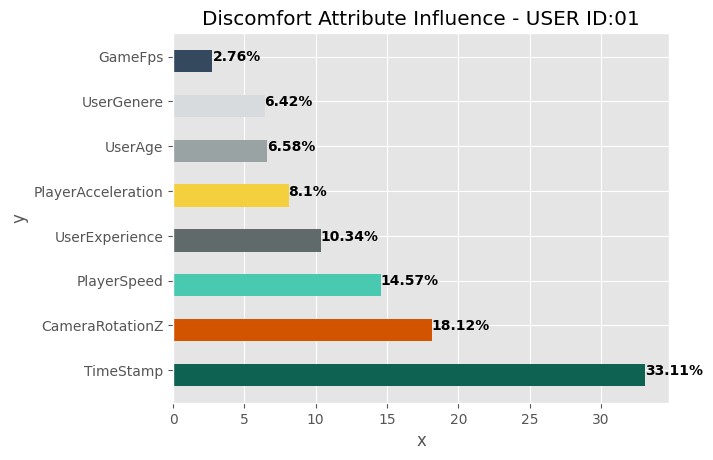

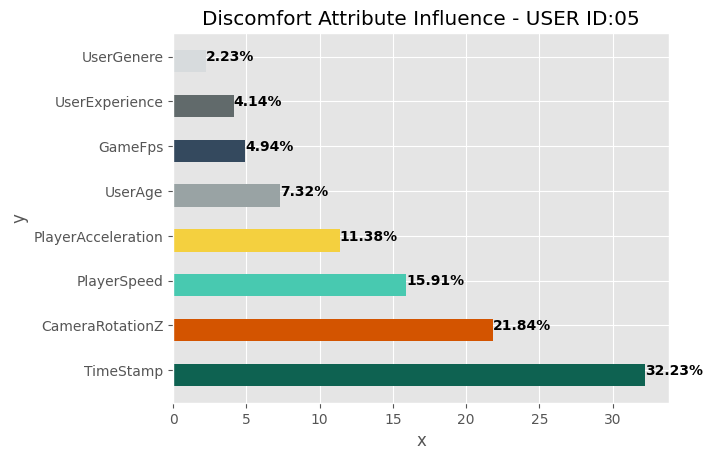

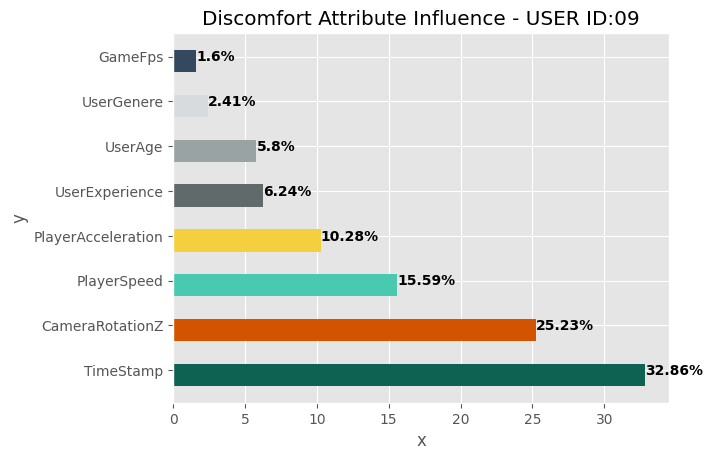

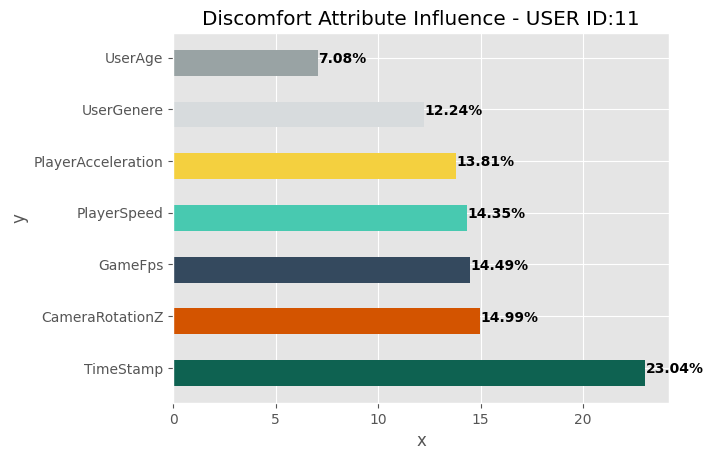

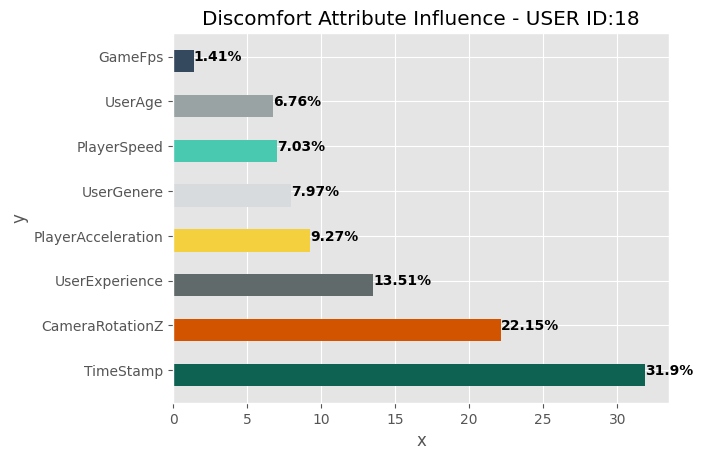

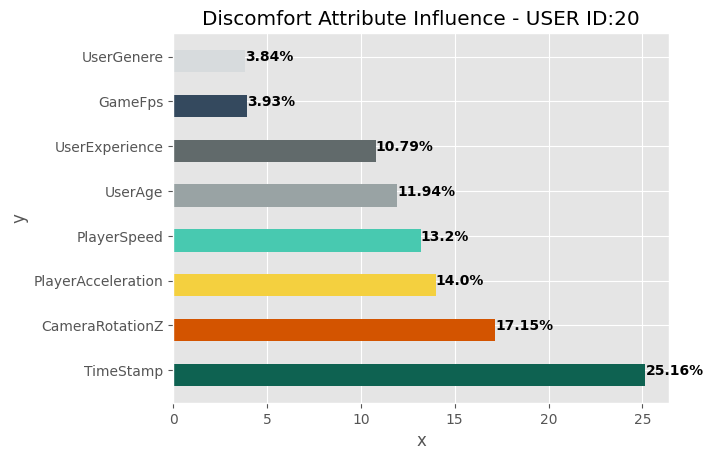

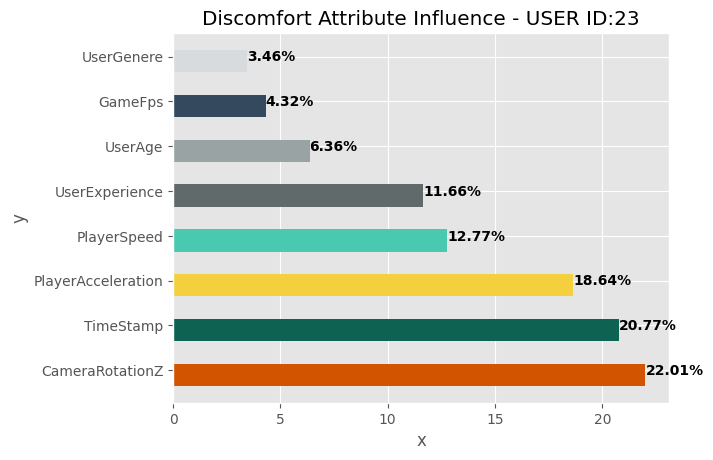

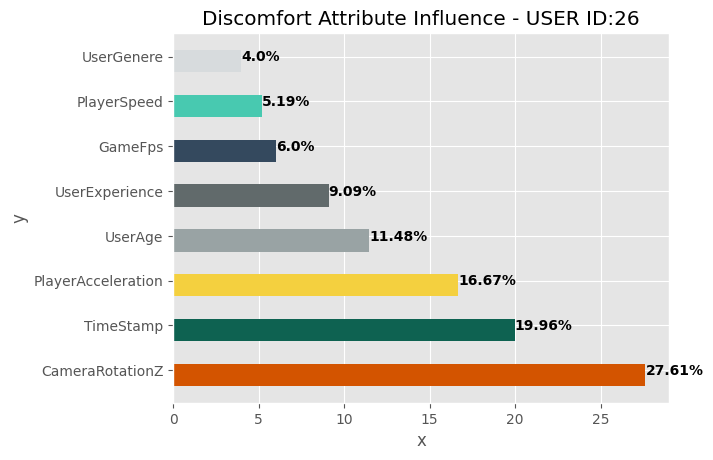

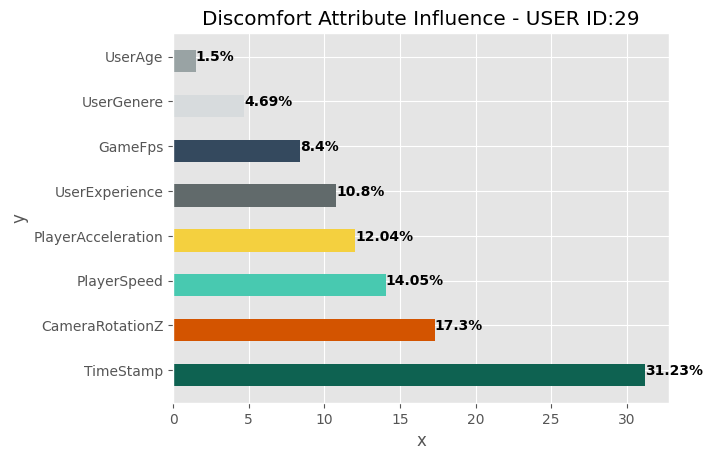

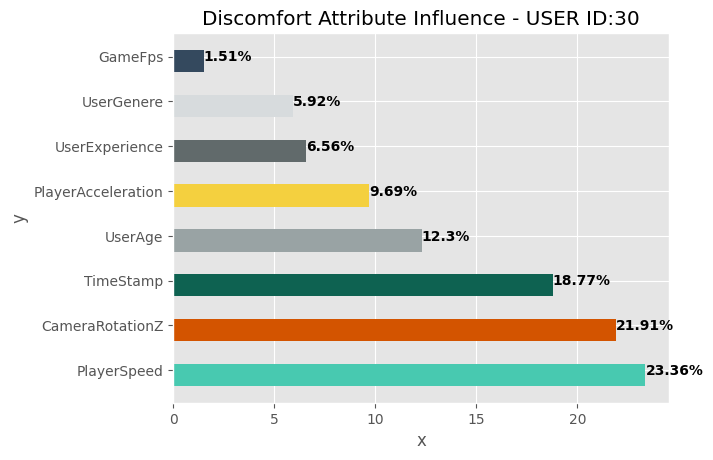

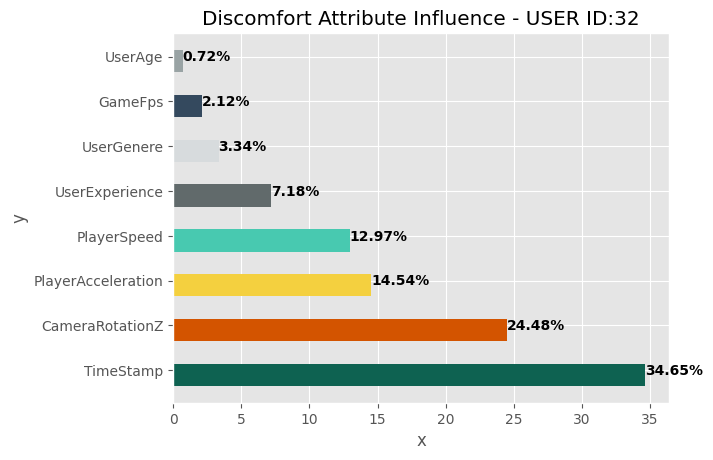

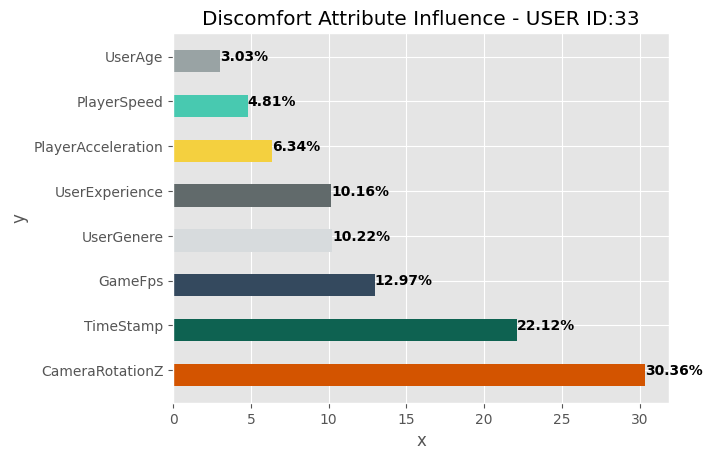

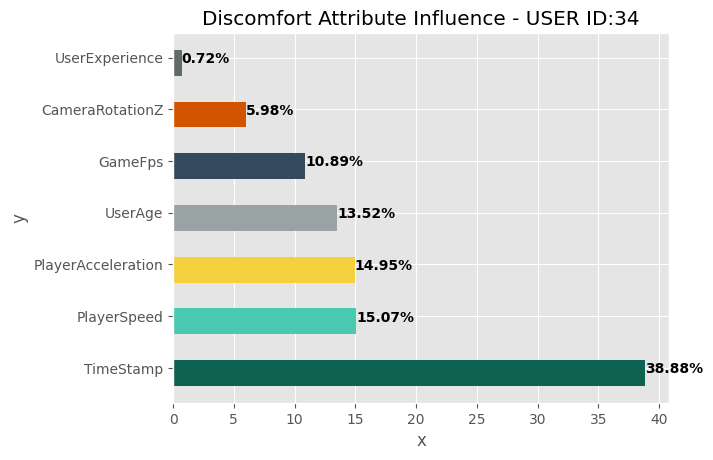

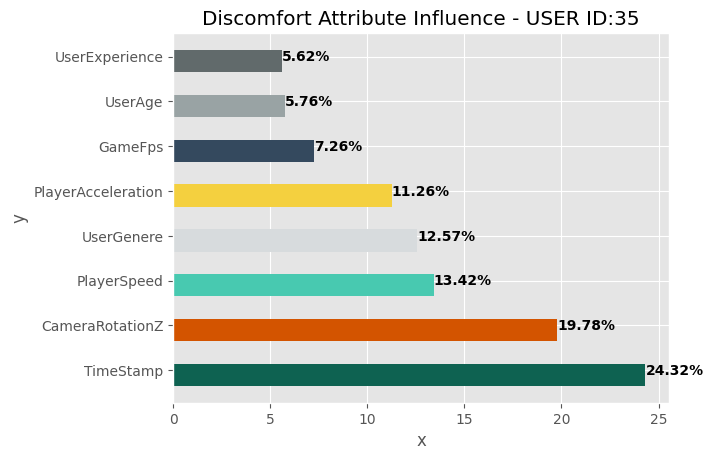

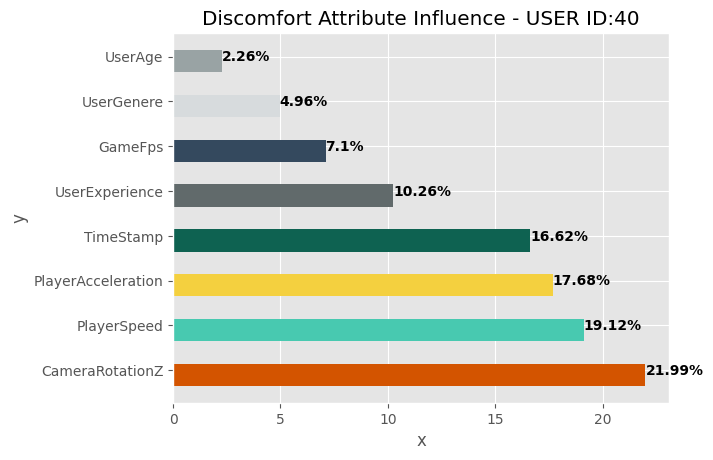

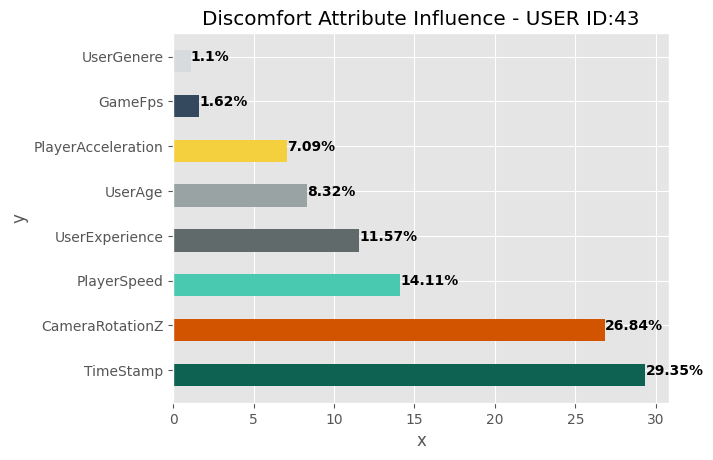

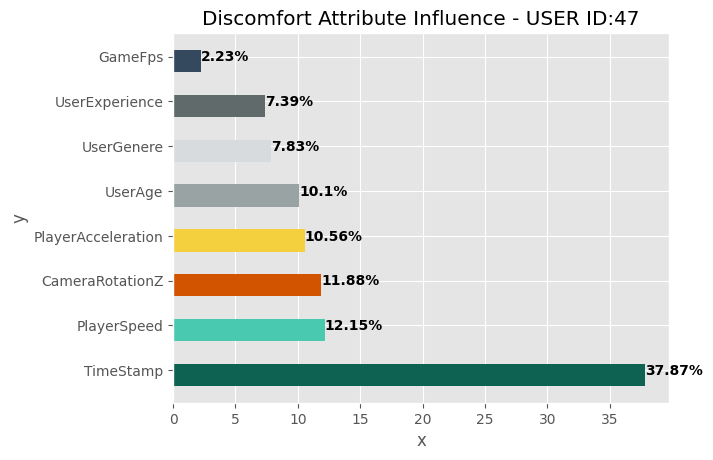

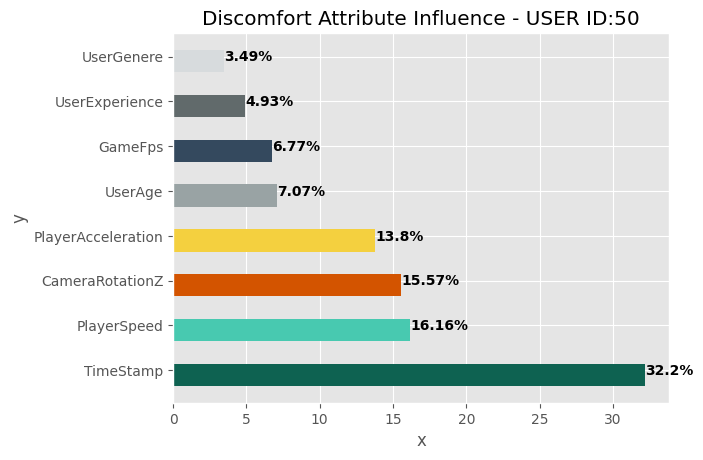

time: 28min 13s (started: 2024-11-30 00:05:14 +00:00)


In [ ]:
# databaseB = '/content/DATABASE/DATABASE_PASSARO/'
databaseB = dbFlightGAME

# PREDICAO JOGO DO PASSARO - PREDICAO DE DESCONFORTO PARA USUARIOS
# TestUsersB =  ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20']
TestUsersB = usersFlight
BRF = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []
for userB in TestUsersB:
    print(userB)
    r = PredictDiscomfortAndCausesFromUserOutTrainingRF(databaseB, userB, 9, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    BRF.append(r)

In [ ]:
count = 0

for user in BRF:
    print("Usuário", TestUsersB[count])
    display(user.style.hide())
    count+=1
    print("\n")

Usuário 01




Usuário 05


Usuário 09


Usuário 11


Usuário 18


Usuário 20


Usuário 23




Usuário 26




Usuário 29




Usuário 30




Usuário 32




Usuário 33




Usuário 34




Usuário 35




Usuário 40




Usuário 43




Usuário 47




Usuário 50




time: 991 ms (started: 2024-11-30 00:33:33 +00:00)


In [ ]:
def binary(x):
    return 1 if (x > 0) else 0

count = 0
fileXML = '/FILE.xml'
predRFB = pd.DataFrame()
for user in BRF:
    predInst = []

    idx = TestUsersB[count]
    print("Usuário", idx)
    userC = user.copy()

    # display(userC.style.hide())

    predInst.append(idx)

    dfSize = userC.shape[0]
    if(dfSize > 0):
        userC['prediction ' + idx] = userC['prediction ' + idx].astype(int)
        userC['real ' + idx] = userC['real ' + idx].astype(str).astype(int)
        userC['real ' + idx] = userC['real ' + idx].apply(binary)

        realDft = userC['real ' + idx].sum() / dfSize
        predInst.append(realDft)
        predDft = userC['prediction ' + idx].sum() / dfSize
        predInst.append(predDft)

        print('realDcfrt:', format(realDft, ".2f"))
        print('predDcfrt:', format(predDft, ".2f"))
    else:
        dftData = parse_XML(dbFlightGAME + idx + fileXML)['DiscomfortLevel']
        dftData = dftData.astype(str).astype(int)
        dftData = dftData.apply(binary)

        realDft = dftData.sum() / size(dftData)
        predInst.append(realDft)
        predDft = 0
        predInst.append(predDft)

        print('realDcfrt:', format(realDft, ".2f"))
        print('None Discomfort Predicted by RF')

    df = pd.DataFrame([predInst], columns=['ID', 'Real', 'Prediction'])
    predRFB = pd.concat([predRFB, df], ignore_index=True)
    count+=1
    print()

display(predRFB.style.hide())

Usuário 01
realDcfrt: 0.06
predDcfrt: 0.44

Usuário 05
realDcfrt: 0.92
predDcfrt: 0.45

Usuário 09
realDcfrt: 0.28
predDcfrt: 0.35

Usuário 11
realDcfrt: 0.69
predDcfrt: 0.48

Usuário 18
realDcfrt: 0.46
predDcfrt: 0.44

Usuário 20
realDcfrt: 0.10
predDcfrt: 0.42

Usuário 23
realDcfrt: 0.47
predDcfrt: 0.44

Usuário 26
realDcfrt: 0.41
predDcfrt: 0.49

Usuário 29
realDcfrt: 0.99
predDcfrt: 0.81

Usuário 30
realDcfrt: 0.71
predDcfrt: 0.47

Usuário 32
realDcfrt: 0.29
predDcfrt: 0.40

Usuário 33
realDcfrt: 0.77
predDcfrt: 0.21

Usuário 34
realDcfrt: 0.36
predDcfrt: 0.00

Usuário 35
realDcfrt: 0.00
predDcfrt: 0.49

Usuário 40
realDcfrt: 0.51
predDcfrt: 0.24

Usuário 43
realDcfrt: 0.46
predDcfrt: 0.42

Usuário 47
realDcfrt: 0.48
predDcfrt: 0.12

Usuário 50
realDcfrt: 0.00
predDcfrt: 0.51



time: 111 ms (started: 2024-11-30 00:33:41 +00:00)


A saída de streaming foi truncada nas últimas 5000 linhas.
Sample:  [ 1.000000e+00  0.000000e+00  0.000000e+00  6.995866e+00  2.800000e+01
  8.000000e+00 -1.305508e-03  9.000000e+01]
None Discomfort Predicted by RF
Sample: 9 of 303
Sample:  [1.000000e+00 0.000000e+00 0.000000e+00 8.000226e+00 4.700000e+01
 1.900000e+01 1.274626e-02 9.000000e+01]
None Discomfort Predicted by RF
Sample: 10 of 303
Sample:  [1.000000e+00 0.000000e+00 0.000000e+00 8.994935e+00 6.500000e+01
 1.800000e+01 3.089379e-02 9.000000e+01]
None Discomfort Predicted by RF
Sample: 11 of 303
Sample:  [ 1.000000e+00  0.000000e+00  0.000000e+00  9.999728e+00  5.900000e+01
 -6.000000e+00  1.176467e-02  8.800000e+01]
None Discomfort Predicted by RF
Sample: 12 of 303
Sample:  [ 1.000000e+00  0.000000e+00  0.000000e+00  1.099586e+01  4.100000e+01
 -1.800000e+01  1.220650e-02  9.000000e+01]
None Discomfort Predicted by RF
Sample: 13 of 303
Sample:  [1.000000e+00 0.000000e+00 0.000000e+00 1.199908e+01 5.700000e+01
 1.600000e+01

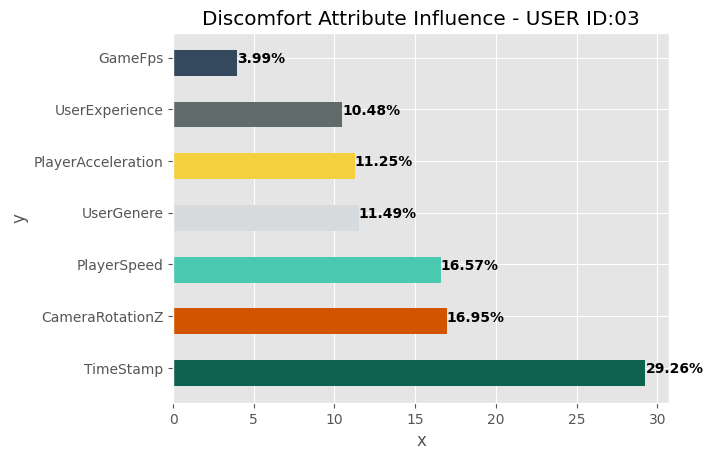

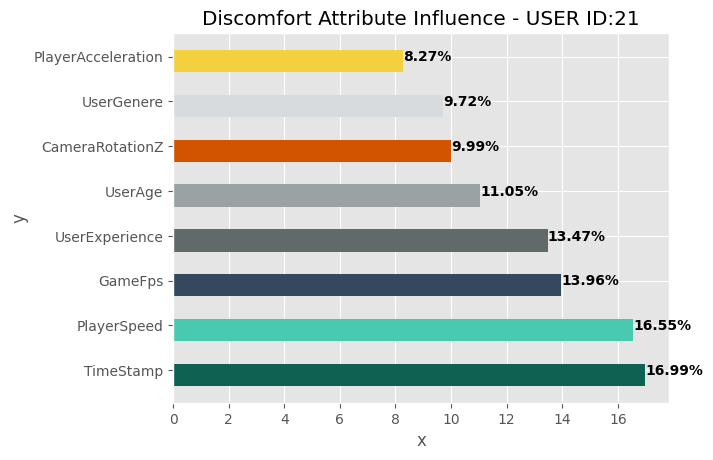

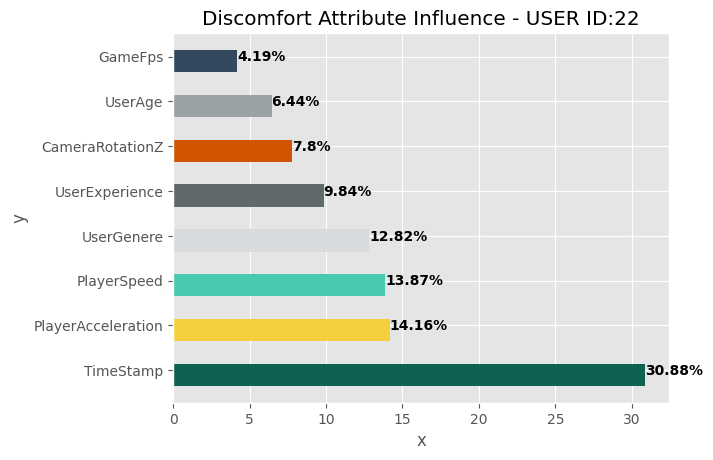

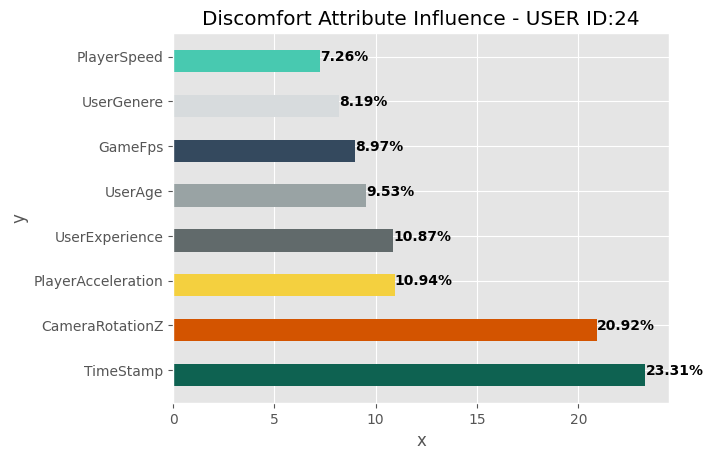

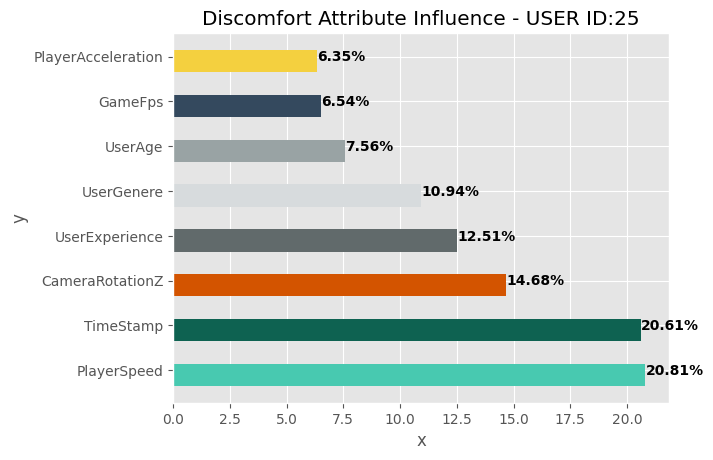

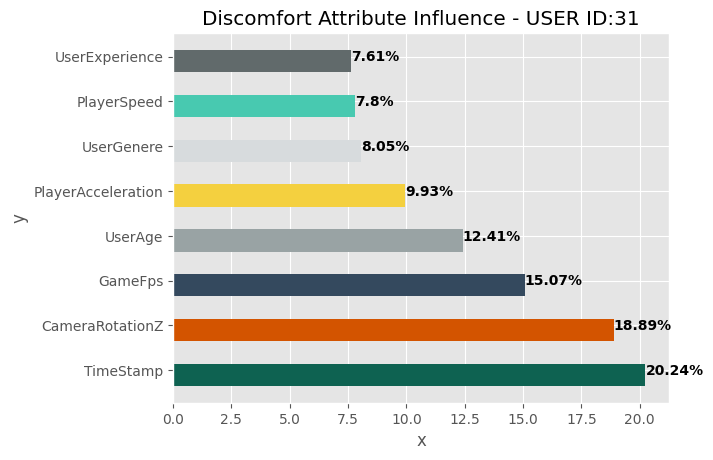

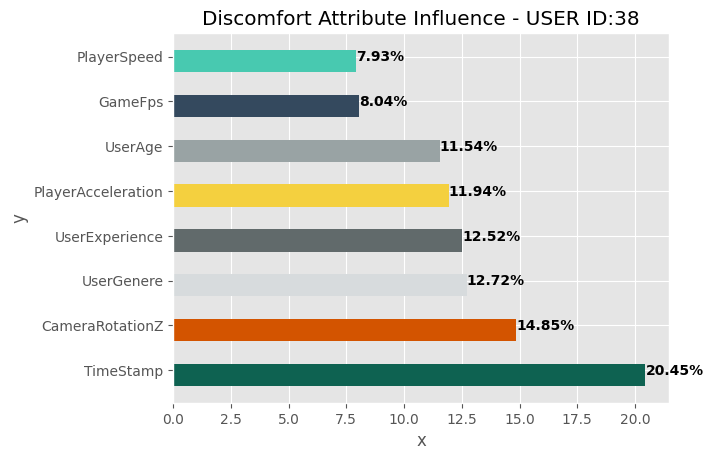

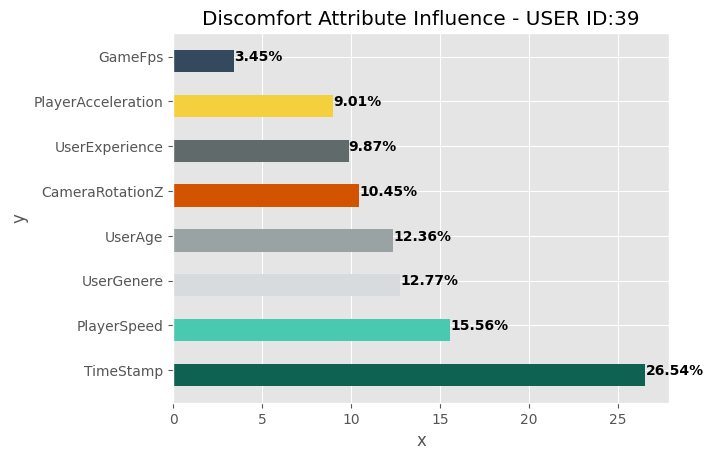

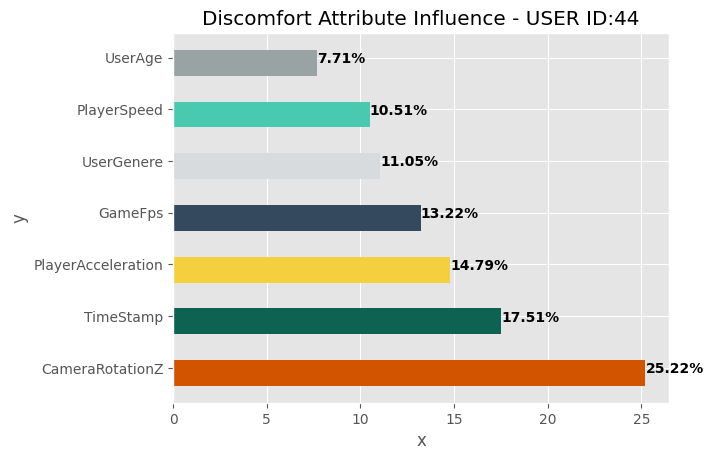

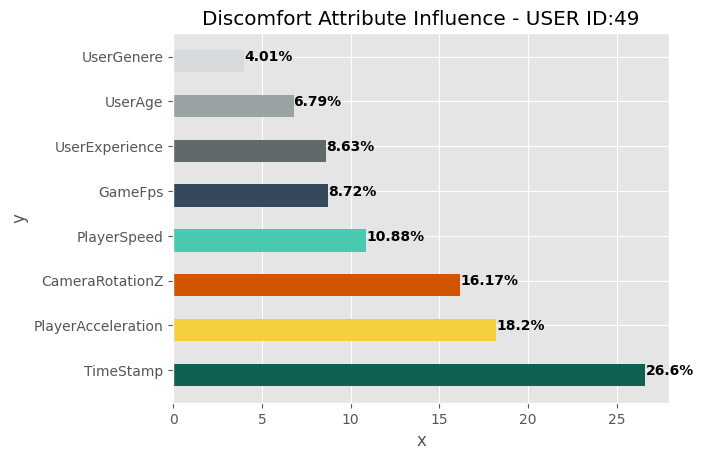

time: 24min 27s (started: 2024-11-30 00:33:49 +00:00)


In [ ]:
# databaseA = '/content/DATABASE/DATABASE_CARRO/'
databaseA = dbRaceGAME

# PREDICAO JOGO DO CARRO - PREDICAO DE DESCONFORTO PARA USUARIOS
# TestUsersA =  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']
TestUsersA = usersRace
ARF = []
#features = ['UserGenere', 'UserAge', 'UserExperience','TimeStamp','PlayerSpeed','PlayerAcceleration','CameraRotationZ','GameFps']
featuresOut = []

for userA in TestUsersA:
    print(userA)
    r = PredictDiscomfortAndCausesFromUserOutTrainingRF(databaseA, userA, 13, featuresOut) #USANDO A MELHOR PROFUNDIDADE DADA PELO MIN LEAF
    ARF.append(r)

In [ ]:
count = 0

for user in ARF:
    print("Usuário", TestUsersA[count])
    display(user.style.hide())
    count+=1
    print("\n")

Usuário 03




Usuário 14




Usuário 21




Usuário 22




Usuário 24




Usuário 25




Usuário 31




Usuário 38




Usuário 39




Usuário 44




Usuário 49




time: 456 ms (started: 2024-11-30 00:59:01 +00:00)


In [ ]:
count = 0
fileXML = '/FILE.xml'
predRFA = pd.DataFrame()
for user in ARF:
    predInst = []

    idx = TestUsersA[count]
    print("Usuário", idx)
    userC = user.copy()

    # display(userC.style.hide())

    predInst.append(idx)

    dfSize = userC.shape[0]
    if(dfSize > 0):
        userC['prediction ' + idx] = userC['prediction ' + idx].astype(int)
        userC['real ' + idx] = userC['real ' + idx].astype(str).astype(int)
        userC['real ' + idx] = userC['real ' + idx].apply(binary)

        realDft = userC['real ' + idx].sum() / dfSize
        predInst.append(realDft)
        predDft = userC['prediction ' + idx].sum() / dfSize
        predInst.append(predDft)

        print('realDcfrt:', format(realDft, ".2f"))
        print('predDcfrt:', format(predDft, ".2f"))
    else:
        dftData = parse_XML(dbRaceGAME + idx + fileXML)['DiscomfortLevel']
        dftData = dftData.astype(str).astype(int)
        dftData = dftData.apply(binary)

        realDft = dftData.sum() / size(dftData)
        predInst.append(realDft)
        predDft = 0
        predInst.append(predDft)

        print('realDcfrt:', format(realDft, ".2f"))
        print('None Discomfort Predicted by RF')

    df = pd.DataFrame([predInst], columns=['ID', 'Real', 'Prediction'])
    predRFA = pd.concat([predRFA, df], ignore_index=True)
    count+=1
    print()

display(predRFA.style.hide())

Usuário 03
realDcfrt: 0.88
predDcfrt: 0.65

Usuário 14
realDcfrt: 0.34
None Discomfort Predicted by RF

Usuário 21
realDcfrt: 0.41
predDcfrt: 0.49

Usuário 22
realDcfrt: 0.00
predDcfrt: 0.48

Usuário 24
realDcfrt: 0.16
predDcfrt: 0.48

Usuário 25
realDcfrt: 0.10
predDcfrt: 0.49

Usuário 31
realDcfrt: 0.96
predDcfrt: 0.31

Usuário 38
realDcfrt: 0.79
predDcfrt: 0.62

Usuário 39
realDcfrt: 0.00
predDcfrt: 0.63

Usuário 44
realDcfrt: 0.00
predDcfrt: 0.71

Usuário 49
realDcfrt: 0.00
predDcfrt: 0.38



time: 296 ms (started: 2024-11-30 00:59:09 +00:00)


# 4. Análise dos Dados do EGG e Cálculo da Coerência dos Valores

In [ ]:
eggA = eggToDataFrame(dbRaceEGG)
display(eggA.style.hide())

eggB = eggToDataFrame(dbFlightEGG)
display(eggB.style.hide())

time: 1.64 s (started: 2024-11-30 01:04:37 +00:00)


In [ ]:
eggDF = pd.concat([eggA, eggB], ignore_index=True)
display(eggDF.style.hide())

# vrsqDF = pd.concat([vrsqA[0], vrsqB[0]], ignore_index=True)
# display(vrsqDF.style.hide())

predDF = pd.concat([predRFA, predRFB], ignore_index=True)
display(predDF.style.hide())

time: 23.2 ms (started: 2024-11-30 01:04:42 +00:00)


In [ ]:
def convertEggVar(x):
    return 0 if(x < 1) else 1
def convertCSLvl(x):
    return 0 if (x < 0.5) else 1


resultDF = pd.DataFrame()

resultDF['ID'] = eggDF['ID']
resultDF['Var'] = abs(eggDF['Game'] - eggDF['Base'])
resultDF['Real'] = predDF['Real']
resultDF['Pred'] = predDF['Prediction']
# display(resultDF.style.hide())

resultDF['Var'] = resultDF['Var'].apply(convertEggVar)
resultDF['Real'] = resultDF['Real'].apply(convertCSLvl)
resultDF['Pred'] = resultDF['Pred'].apply(convertCSLvl)
display(resultDF.style.hide())

total = resultDF.shape[0]

coerReal = (resultDF['Var'] == resultDF['Real']).sum() / total
print("Coerência com Desconforto Relatado:", format(coerReal*100, ".2f"))
coerPred = (resultDF['Var'] == resultDF['Pred']).sum() / total
print("Coerência com Desconforto Previsto:", format(coerPred*100, ".2f"))
coerTotal = ((resultDF['Var'] == resultDF['Real']) & (resultDF['Var'] == resultDF['Pred'])).sum() / total
print("Coerência com Ambos:", format(coerTotal*100, ".2f"))
coerModel = (resultDF['Pred'] == resultDF['Real']).sum() / total
print("Coerência do Modelo:", format(coerModel*100, ".2f"))

Coerência com Desconforto Relatado: 65.52
Coerência com Desconforto Previsto: 55.17
Coerência com Ambos: 44.83
Coerência do Modelo: 68.97
time: 21.8 ms (started: 2024-11-30 01:04:46 +00:00)
